<a href="https://colab.research.google.com/github/Raoufmamedov/various_studies/blob/main/baseline_v1_new__colab_correct_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture

# установка дополнительных библиотек:
!pip install Afinn
!pip install nltk[twitter]
!conda install -c conda-forge --yes pycountry
!pip install countryinfo
!pip install pycountry_convert
!pip install geopy
!pip install Nominatim
!pip install country_converter

In [ ]:
# инструменты загрузки анализа и обработки данных
import os
import pandas as pd
import numpy as np
# import re
import geopy.distance
import pycountry_convert as pc
import country_converter as coco
from scipy import stats
# from category_encoders import  OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import f_classif, chi2
from countryinfo import CountryInfo

# инструменты для лингвистического анализа:
# import string
# import spacy
import nltk
from nltk.corpus import stopwords
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
# from textblob import TextBlob, Blobber
# from textblob.sentiments import NaiveBayesAnalyzer
# from afinn import Afinn
from wordcloud import WordCloud

# инструменты для визуализации:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# параметры отображения содержимого на экране:
from IPython.display import display
from IPython.display import Image
from termcolor import colored
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_rows', 100)

# инструменты для построения модели:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')

# фиксируем RANDOM_SEED и версию пакетов, чтобы эксперименты были воспроизводимы:
RANDOM_SEED = 42
!pip freeze > requirements.tx

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### **Пользовательские функции**

In [ ]:
# Функция оценки значимости числового признака, выдаёт список значимых признаков
def anovaboxing(features, threshold=50):
    global anovabox
    datatester=pd.concat([anovabox, features], axis=1)
    y = datatester.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
    X = datatester.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)


    imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
    imp_new = imp_num[imp_num>threshold]
    imp_new.sort_values(inplace = True)
    display(imp_new)

    fig5, ax5 = plt.subplots(figsize=(18, 9))
    imp_new.plot(kind = 'barh', color='lightblue');
    return list(imp_new.index)

# Аналогичная функция оценки значимости категориального признака (можно было бы объединить с предыдущим)

def chiboxing(features, threshold=500):
    global chibox
    datatester=pd.concat([chibox, features], axis=1)
    y = datatester.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
    X = datatester.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)
    y=y.astype(int)

    imp_num = pd.Series(chi2(X[X.columns], y)[0], index = X.columns)
    imp_new = imp_num[imp_num>threshold]
    imp_new.sort_values(inplace = True)
    display(imp_new)

    fig5, ax5 = plt.subplots(figsize=(18, 9))
    imp_new.plot(kind = 'barh', color='lightblue');
    return list(imp_new.index)

# Модуль автоматического создания бинарных признаков из серии/датафрейма по списку и условиям
# При выборе флага r вносит изменения в датафрейм, в противном случае создаётся "виртуальный" массив
# признаков подаваемый в анализатор значимости. При необходимости, создаваемый признак маркируется суффиксом
# задаваемым пользователем

def bin_creator(featurewords_list, series, mode='v', suff=""):
    if mode==('r' or 'R'):
        df=data
    else:
        df=data.copy()
    for word in featurewords_list:
        df[str(word)+str(suff)]=np.where(series.str.contains(word), True, False)
    featurewords_list=list([str(i)+str(suff) for i in featurewords_list])
    return df[featurewords_list], featurewords_list

# Модуль создания массива фиктивных переменных из серии
def dummifier(dataframe):
    dummy_frame=pd.get_dummies(dataframe)
    return dummy_frame

# модуль удаления высококоррелированных признаков по списку и обновления списка признаков.
def featdropper(df, list2drop):
    df.drop(list2drop, axis=1, inplace=True)
    return df.columns

In [ ]:
# Создание стоп-листов
def stopworder(swl):
    stopwords=nltk.corpus.stopwords.words("english")
    stopwords.extend(swl)
    return stopwords


In [ ]:
# def virtualbinarizer(series, featurewords_list):
# #     virtdata=data[['sample, reviever_score']].copy()
#     virtbins=chiboxing(bin_creator(featurewords_list, series.copy()))
#     return virtbins
# #     virtdata=pd.concat(virtdata, virtbins)



In [ ]:
# Модуль создания облака тегов и выдачи статистики встречаемости слов.
def nltkzer(data, column, stopwords):
    data[str(column)+"_tok"]=data[column].str.lower().apply(lambda x: nltk.word_tokenize(x))
    data[str(column)+"_tok"]=data[str(column)+"_tok"].apply(lambda x: [item for item in x if item not in stopwords])
    data[str(column)+"_words_"]=data[str(column)+"_tok"].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
    all_words=' '.join([word for word in data[str(column)+"_words_"]])
    tokenized_words = nltk.tokenize.word_tokenize(all_words)
    fdist = FreqDist(tokenized_words)
    fdist.most_common(100)
    data[str(column)+'text_string_fdist'] = data[str(column)+"_tok"].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 2 ]))
    wordnet_lem = WordNetLemmatizer()
    data[str(column)+'text_string_lem'] = data[str(column)+'text_string_fdist'].apply(wordnet_lem.lemmatize)
    all_words_lem = ' '.join([word for word in data[str(column)+'text_string_lem']])

    wordcloud = WordCloud(width=1200,
                         height=800,
                         random_state=2,
                         max_font_size=100).generate(all_words_lem)

    plt.figure(figsize=(16, 18))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off');

    return fdist

In [ ]:
# Извлечение почтового индекса из строки с адресом (позаимствовано у Margarita Kr)
def get_postcode(address):
    address_list = address.split()
    postcode_place = {
        'Kingdom': -4,
        'Spain': -3,
        'France': -3,
        'Austria': -3,
        'Netherlands': -4,
        'Italy': -3
    }
    postcode = str(address_list[postcode_place[address_list[-1]]])

    if address_list[-1] == 'Kingdom' and postcode[-1].isalpha():
        return postcode[:-1]
    else:
        return postcode

#### **Зaгрузка данных**

In [ ]:
# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# # Подгрузим наши данные из соревнования
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# # данные из соревнования
# DATA_DIR = '/kaggle/input/sf-booking/'
# df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv')
# df_test = pd.read_csv(DATA_DIR+'hotels_test.csv')
# sample_submission = pd.read_csv(DATA_DIR+'/submission.csv')

# # объединяем трейн и тест в один датасет
# df_train['sample'] = 1 # помечаем трейн
# df_test['sample'] = 0 # помечаем тест

# # в тесте у нас нет значения reviewer_score, заполняем нулями:
# df_test['reviewer_score'] = 0

# # Загружаем специальный удобный инструмент для разделения датасета:
# from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Подгрузим наши данные из соревнования
for dirname, _, filenames in os.walk('/content/drive/MyDrive/BOOKING'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/BOOKING/hotels_test.csv.zip
/content/drive/MyDrive/BOOKING/hotels_train.csv.zip
/content/drive/MyDrive/BOOKING/submission.csv.zip
/content/drive/MyDrive/BOOKING/submission_old.csv
/content/drive/MyDrive/BOOKING/submission_g.csv
/content/drive/MyDrive/BOOKING/submission7.csv
/content/drive/MyDrive/BOOKING/submission.csv


In [ ]:
# данные из соревнования
DATA_DIR = '/content/drive/MyDrive/BOOKING'
df_train = pd.read_csv('/content/drive/MyDrive/BOOKING/hotels_train.csv.zip')
df_test = pd.read_csv('/content/drive/MyDrive/BOOKING/hotels_test.csv.zip')
sample_submission = pd.read_csv('/content/drive/MyDrive/BOOKING/submission.csv.zip')

# объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем трейн
df_test['sample'] = 0 # помечаем тест

# в тесте у нас нет значения reviewer_score, заполняем нулями:
df_test['reviewer_score'] = 0

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

Загружаем данные и создаём датафрейм в который мы будем интегрировать проверяемые серии проверяемых признаков.

In [ ]:
# Загрузка данных и создание служебного датафрейма направляемого для в модуль проверки значимости признаков chiboxing.

data = df_test.append(df_train, sort=False).reset_index(drop=True)
anovabox=data[['sample', 'reviewer_score']].copy()
chibox=data[['sample', 'reviewer_score']].copy()

## **ПОСТАНОВКА ЗАДАЧИ.**

Построение модели на данных Booking, позволяющей предсказывать ожидаемый рейтинг и выявлять нечестные отели, которые накручивают себе рейтинг.



## **ОБРАБОТКА И АНАЛИЗ ИСХОДНЫХ ДАННЫХ**

Для начала, очистим все имеющиеся строки записей от пробелов, которые могут привести к некорректной обработке данных. После этого посмотрим какими данными мы обладаем.

In [ ]:
data[data.select_dtypes(['object']).columns] = data.select_dtypes(['object']).apply(lambda x:
                                                                                    x.str.strip())
display(data.info(False))
original_features_info=pd.concat([data.count(), data.isna().sum(), data.dtypes, data.nunique(dropna=False)],
                                 axis=1)

original_features_info.columns=["Qty", "NA",'Dtype', "NUnique"]
original_features_info.sort_values(by=['Dtype',"NUnique"], inplace=True)
display(original_features_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Columns: 18 entries, hotel_address to reviewer_score
dtypes: float64(4), int64(6), object(8)
memory usage: 70.8+ MB


None

,Qty,NA,Dtype,NUnique
sample,515738,0,int64,2
total_number_of_reviews_reviewer_has_given,515738,0,int64,198
review_total_positive_word_counts,515738,0,int64,365
review_total_negative_word_counts,515738,0,int64,402
additional_number_of_scoring,515738,0,int64,480
total_number_of_reviews,515738,0,int64,1142
average_score,515738,0,float64,34
reviewer_score,515738,0,float64,38
lat,512470,3268,float64,1473
lng,512470,3268,float64,1473


### **РАЗДЕЛЕНИЕ ПРИЗНАКОВ ПО ТИПУ**

#### **ПРИЗНАКИ В СТРОКОВОМ ФОРМАТЕ**

In [ ]:
objs=data.select_dtypes(include="O")
objs.columns

Index(['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'positive_review', 'tags', 'days_since_review'],
      dtype='object')

Для отеля у нас имеются следующие данные в текстовом формате:
    
1) **'hotel_address'/ (Адрес отеля)**. Из него мы можем извлечь:

* страну нахождения
* индекс почтового отделения и/или региона
* на основании адреса, для отелей без координат GPS можно задаться модальными координатами районов в
    которых они расположены

2) **'review_date'/ (Дата отправки рецензии)**:
* День, Месяц, Год, День недели, день месяца, день года. Признаки будут извлечечены и исследованы вместе
     с  числовыми данными*

3) **'hotel_name'/ (Название отеля)**. Кроме уникального названия отеля,из признака можно извлечь
* признак принадлежности к ведущим гостиничным сетям, предоставляющим услуги в Европе.
* Также, в названии могут содержаться слова определяющие категорию отеля

4) **'reviewer_nationality'/(Гражданство рецензента)** . Здесь может наблюдаться тенденция более высоких оценок рецензентами одной группы стран в сравнении с оценками даваемыми рецензентами другой группы.

5) **'negative_review', 'positive_review', 'tags'/(Отрицательные отзывы, Положительные отзывы, тэги):** Данная группа признаков будет обрабатываться с применением средств лингвистического анализа текстов

6) **'days_since_review'/ (Количество дней со дня рецензии)**. На самом деле числовой признак угодивший в строковые признаки из-за приписки day/days. Будет проанализирован с числовыми переменными.

        

#### **1) 'hotel_name'**

Для начала проверим, имеются ли среди отелей "тёзки", расположенные в разных городах и укажем в названиях город в котором они находятся

In [ ]:
hotel_number=data.groupby(['hotel_name'])['hotel_address'].unique()
for num, i in enumerate(hotel_number):
    if len(i)>1:
        hname=hotel_number.index[num]
        print(hname, i)
choices=['Bergara 2 4 Eixample 08002 Barcelona Spain',
         'Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria',
         'Via Cesare Correnti 13 Milan City Center 20123 Milan Italy']

options=['Hotel Regina Barcelona', 'Hotel Regina Vienna', 'Hotel Regina Milan' ]

# Добавление города в название отеля
for i in range(len(choices)):
    data.loc[data.hotel_address==choices[i], 'hotel_name']=options[i]

Hotel Regina ['Bergara 2 4 Eixample 08002 Barcelona Spain'
 'Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria'
 'Via Cesare Correnti 13 Milan City Center 20123 Milan Italy']


Попробуем вычленить из названия отеля его тип, категорию, иную полезную информацию , и соответствующие переменные сделаем бинарными. Для исследования названия, мы будем использовать средства предоставляемые библиотекой NLTK.

In [ ]:
stopwords=nltk.corpus.stopwords.words("english")

hotelname_sl = ["hotel", "london", "amsterdam", "hotels", "raddison", "plaza", "club quarters", "blu edwardian", "doubletree"]
# hn_stopwords=stopworder(hotelname_sl)

stopwords.extend(hotelname_sl)

,Freq
park,43929
hilton,35490
paris,21792
grand,18430
inn,18416
barcelona,18354
kensington,18280
city,17659
best,16260
western,16260


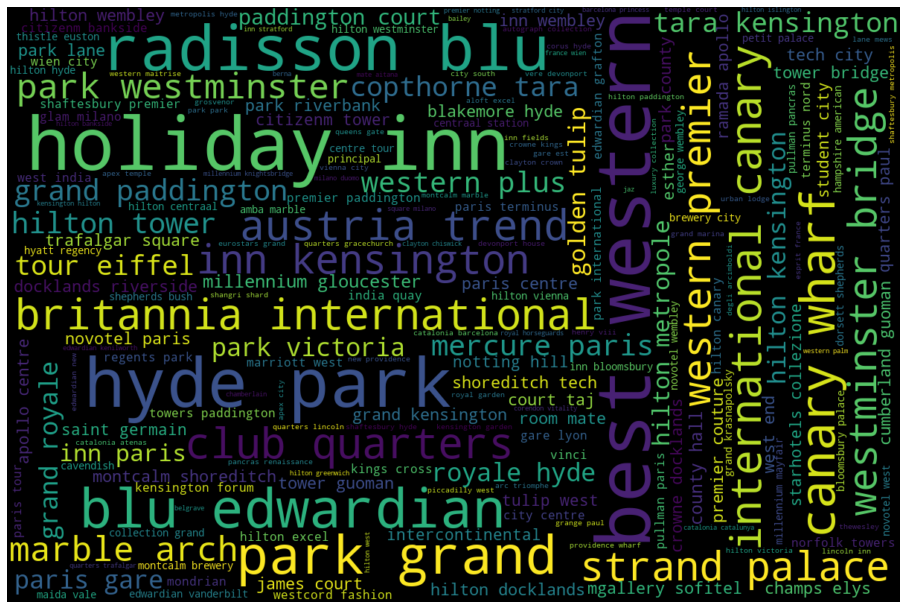

In [ ]:
word_dist=nltkzer(data, 'hotel_name', stopwords)
hn_wordfreq=pd.DataFrame([word_dist]).T.rename(columns={0:"Freq"}).sort_values('Freq', ascending=False)
display(hn_wordfreq.head(20))

Визуально подбираем самые часто встречающиеся слова и словосочетания и проверяем их, порог отсечения категориальных признаков - 500

Подбираем слова, наличие которых в названии отеля значимо связано с целевой переменной. В ноутбуке указаны признаки прошедшие отбор.

paddington                                    711.892
holiday inn                                   735.424
kensington                                    788.239
park                                          788.239
best_western                                  899.111
Britannia International Hotel Canary Wharf   3504.086
dtype: float64

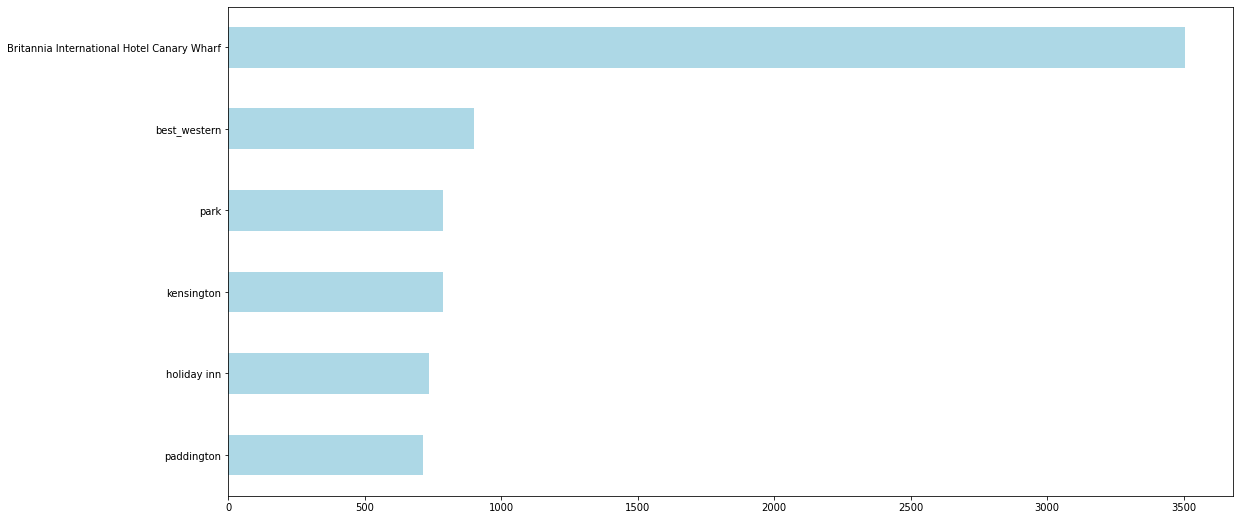

In [ ]:
data['best_western']=np.where(data['hotel_name'].str.lower().str.contains('best western'), True, False)
data['holiday inn']=np.where(data['hotel_name'].str.lower().str.contains('holiday inn'), True, False)
data['Britannia International Hotel Canary Wharf']=np.where(data['hotel_name'].str.lower().str.contains('britannia international hotel canary wharf'), True, False)
data['kensington']=np.where(data['hotel_name'].str.lower().str.contains(('kensington' and 'padington') and 'park'), True, False)
data['park']=np.where(data['hotel_name'].str.lower().str.contains('park'), True, False)
data['paddington']=np.where(data['hotel_name'].str.lower().str.contains('paddington'), True, False)

man_sel_hnwords=data[['best_western', 'holiday inn', 'Britannia International Hotel Canary Wharf', 'kensington',
     'park',  'paddington']]

hn_man=chiboxing(man_sel_hnwords)

Теперь пробуем создать признаки автоматически.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Grand Royale London Hyde Park                 551.241
The Cumberland A Guoman Hotel                 562.397
BEST WESTERN Maitrise Hotel Maida Vale        581.751
Holiday Inn London Kensington                 588.408
NH Carlton Amsterdam                          596.430
Shaftesbury Premier London Paddington         609.032
Park Lane Mews Hotel                          665.180
Hyatt Regency Paris Etoile                    702.817
Gainsborough Hotel                            740.516
Henry VIII                                    843.344
Hilton London Metropole                       874.844
Bloomsbury Palace Hotel                      1000.228
Commodore Hotel                              1065.862
Hotel Cavendish                              1123.244
Intercontinental London The O2               1134.637
Britannia International Hotel Canary Wharf   3504.086
dtype: float64

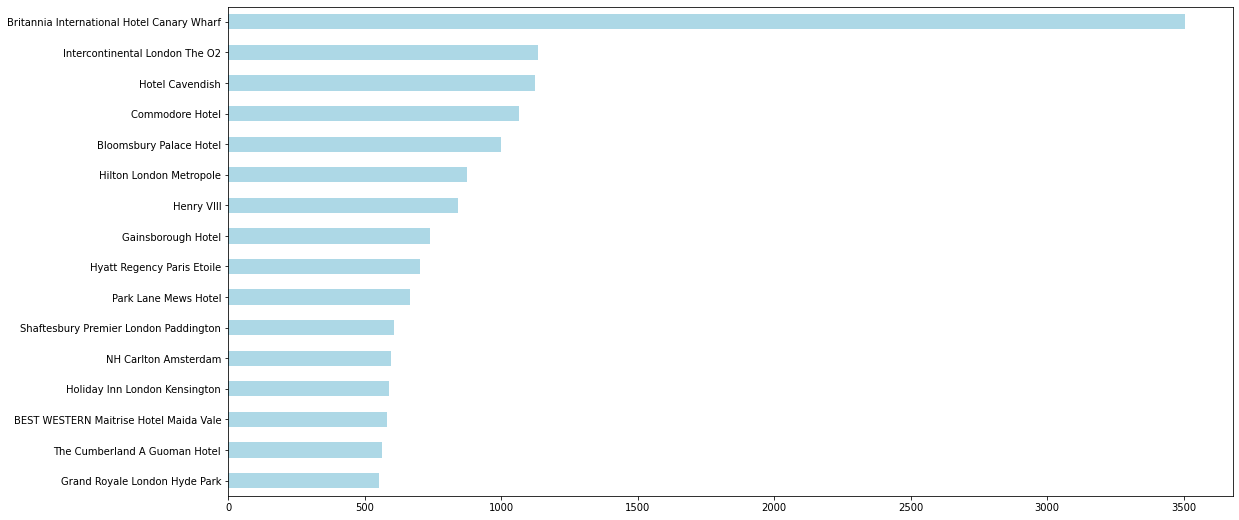

In [ ]:
hn_auto=(bin_creator(chiboxing(bin_creator(data.hotel_name.value_counts().nlargest(500).index, data.hotel_name, "v")[0], 500), data.hotel_name, 'r')[1])

In [ ]:
# hn_auto=chibox(bin_creator(hnmosts, data.hotel_name, 'r','_hn' )[1], 500)

Как мы видим, полностью полагаться на список нельзя и надо сочетать оба подхода.

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


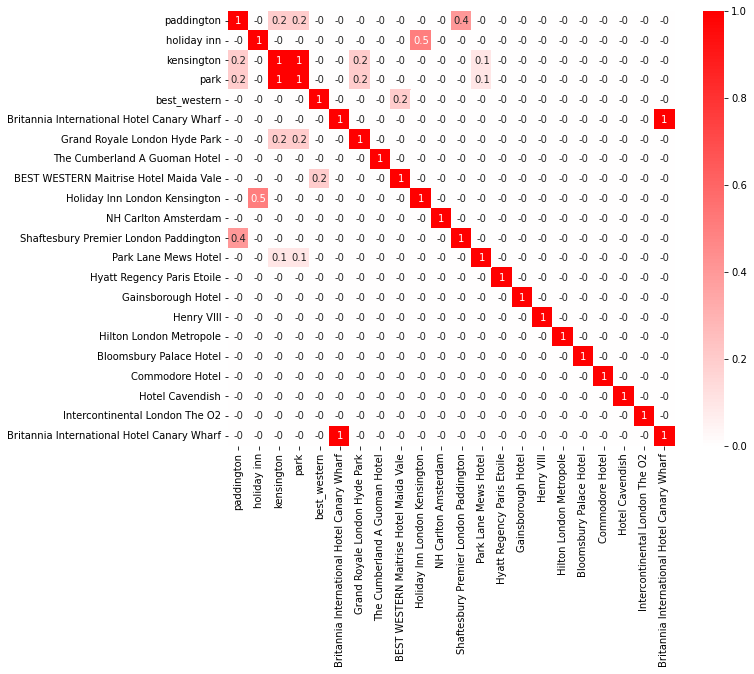

In [ ]:
plt.figure(figsize=(10, 8))
col_2_show=hn_man+hn_auto
sns.heatmap(data[col_2_show].corr('kendall').round(1), annot=True, cmap="bwr", center=0)

Удаляем дубликаты

In [ ]:
featdropper(data, 'Britannia International Hotel Canary Wharf')

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'tags',
       'days_since_review', 'lat', 'lng', 'sample', 'reviewer_score',
       'hotel_name_tok', 'hotel_name_words_', 'hotel_nametext_string_fdist',
       'hotel_nametext_string_lem', 'best_western', 'holiday inn',
       'kensington', 'park', 'paddington', 'Grand Royale London Hyde Park',
       'The Cumberland A Guoman Hotel',
       'BEST WESTERN Maitrise Hotel Maida Vale',
       'Holiday Inn London Kensington', 'NH Carlton Amsterdam',
       'Shaftesbury Premier London Paddington', 'Park Lane Mews Hotel',
       'Hyatt Regency Paris Etoile', 'Gainsborough Hotel', 'Henry VIII',
       'Hilton London Metropole', 'Bloomsbury Palace Hotel

Для большиства отелей, название не сильно связано с оценками пользователей. Отели ряда крупных и популярных сетей (Carlson, Whitbread, Accor, Travelodge) слабо представлены, либо вообще отсутствуют в оценках. Это наводит на мысль о селективности при парсинге сайта, возможно влекущей за собой снижение точности предсказания рейтинга.

Для ряда отелей наблюдается слабая связь с целевой переменной (Best Western, Hyde Park, Mercure, Holiday inn и ряд других отелей).

Рассмотрим теперь самые высокооцениваемые отели (топ-100) по признаку average_score и имеющимся данным по признаку reviewer_score. Несмотря на отсутствие данных по значениям последнего признака,
мы можем предположить что если данные однородные, то и отели популярные в  окажутся таковыми в обучающей выборки и тестовой выборке. Для того чтобы оценить степень разночтений введём параметр консенсуса оценок (est_consensus). Если отель присутствует в обоих топ листах, переменная имеет значение 1, в противном случае значение равно 0.

In [ ]:
reviewer_scores_hotel=data.groupby('hotel_name')['reviewer_score'].agg(['median', pd.Series.mode,
                                                                        'count'])
rev_top_100_hotels=reviewer_scores_hotel.sort_values('median',
                                                 ascending=False).nlargest(100,
                                                                           'median').query('count>100')
rev_top_100_hotels_list=rev_top_100_hotels.index


In [ ]:
average_scores_hotel=data.groupby('hotel_name')['average_score'].agg(['mean','count'])
av_top_100_hotels=average_scores_hotel.sort_values('mean',
                                                   ascending=False).nlargest(100,
                                                                             'mean').query('count>100')
av_top_100_hotels_list=av_top_100_hotels.index

In [ ]:
data['rev_top_100_hotels_list']=data['hotel_name'].apply(lambda x:
                                                         1 if x in rev_top_100_hotels_list
                                                         else 0)

data['av_top_100_hotels_list']=data['hotel_name'].apply(lambda x:
                                                        1 if x in av_top_100_hotels_list
                                                        else 0)

data['est_consensus']=abs(data['av_top_100_hotels_list']-data['rev_top_100_hotels_list'])

est_consensus             1851.488
rev_top_100_hotels_list   7620.211
av_top_100_hotels_list    8166.284
dtype: float64

['est_consensus', 'rev_top_100_hotels_list', 'av_top_100_hotels_list']

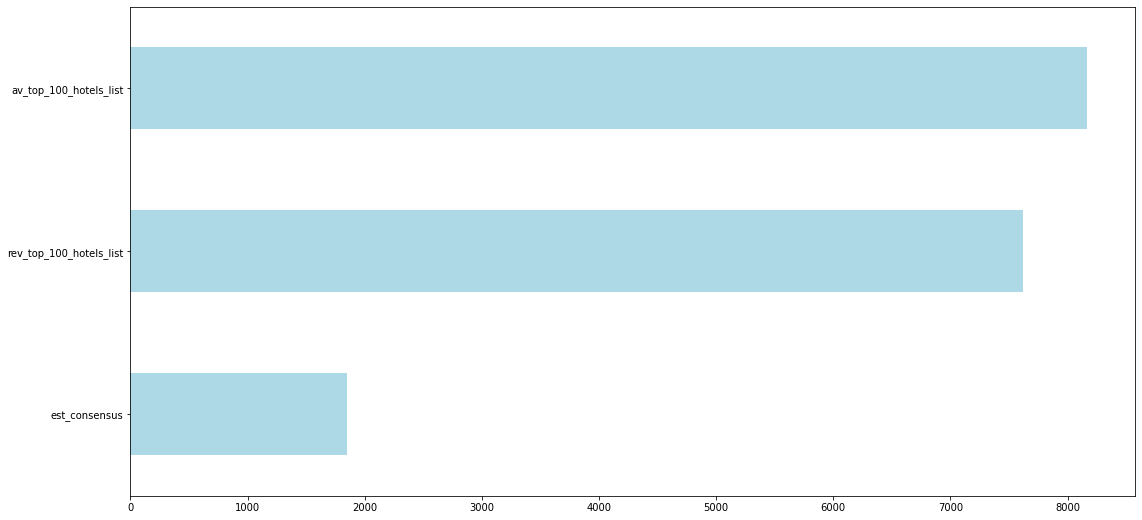

In [ ]:
chiboxing(data[['est_consensus', 'rev_top_100_hotels_list', 'av_top_100_hotels_list']])

Отбираем признаки av_top_100_hotels_list и est_consensus для дальнейшего анализа и проверяем на корреляцию.

In [ ]:
data.query('sample==1')[['est_consensus', 'rev_top_100_hotels_list', 'av_top_100_hotels_list', 'average_score', 'reviewer_score']].corr()

,est_consensus,rev_top_100_hotels_list,av_top_100_hotels_list,average_score,reviewer_score
est_consensus,1.000,0.222,0.316,0.173,0.062
rev_top_100_hotels_list,0.222,1.000,0.832,0.342,0.123
av_top_100_hotels_list,0.316,0.832,1.000,0.358,0.127
average_score,0.173,0.342,0.358,1.000,0.364
reviewer_score,0.062,0.123,0.127,0.364,1.000


#### **'hotel_address'**

Проанализируем облако тэгов адресов. Для начала определим стоп-лист для слов/словосочетаний (слова подобраны ранее по результатам оценки их влияния на модель). После этого предварительно отберём признаки пригодные для моделирования. Для начала извлечём название стран и оценим их значимость.

Признак адреса содержит в себе много полезной информации, которая понадобится нам для заполнения отсутствующих значений и конструирования признаков извлекаем новые признаки.

In [ ]:
# # Вычленяем код страны
data["hotel_country"]=data.hotel_address.apply(lambda x: x.split()[-1])
data["hotel_country"].replace("Kingdom", "United Kingdom", inplace=True)
# pd.concat([data["hotel_country"].value_counts(), 100*round(data["hotel_country"].value_counts(True), 2)], axis=1).T

# # Вычленяем код почтового отделения, для Великобритании индекс выделяем отдельно и заменяем извлечённые коды для этих записей
data['zip_code']=data.hotel_address.apply(get_postcode)
UK_zips=data.hotel_address.str.extract(pat=r'(\b[A-Z]{1,2}[0-9][A-Z0-9]? [0-9][ABD-HJLNP-UW-Z]{2}\b)')
data.loc[data["hotel_country"]=='United Kingdom',
         'zip_code']=UK_zips[data["hotel_country"]=='United Kingdom'].values

data["hotel_country"]=data["hotel_country"].str.strip()

Проверку на значимость при пороге 500, проходит только Великобритания

United Kingdom   537.770
dtype: float64

['United Kingdom']

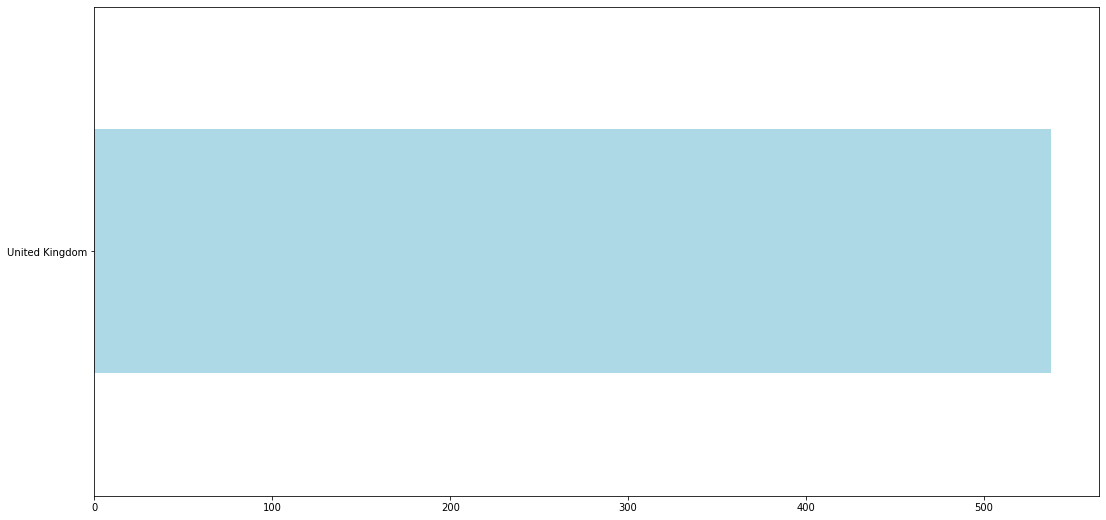

In [ ]:
bin_creator(chiboxing(dummifier(data.hotel_country), 500), data.hotel_country, 'r')[1]

In [ ]:
data.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'tags',
       'days_since_review', 'lat', 'lng', 'sample', 'reviewer_score',
       'hotel_name_tok', 'hotel_name_words_', 'hotel_nametext_string_fdist',
       'hotel_nametext_string_lem', 'best_western', 'holiday inn',
       'kensington', 'park', 'paddington', 'Grand Royale London Hyde Park',
       'The Cumberland A Guoman Hotel',
       'BEST WESTERN Maitrise Hotel Maida Vale',
       'Holiday Inn London Kensington', 'NH Carlton Amsterdam',
       'Shaftesbury Premier London Paddington', 'Park Lane Mews Hotel',
       'Hyatt Regency Paris Etoile', 'Gainsborough Hotel', 'Henry VIII',
       'Hilton London Metropole', 'Bloomsbury Palace Hotel

Теперь рассмотрим почтовые подразделения

In [ ]:
# zip_list=bin_creator(list(chiboxing(dummifier(data.zip_code), 500)), data.zip_code,'v')[0]

Анализ адресов (опущен для кратости) показывает что эти почтовые отделения сильно коррелируют с отелями которые мы уже выделили как значимые. Поэтому добавлять эти признаки мы не будем)

#### **3) 'reviewer_nationality'**

Проанализируем влияние страны постоянного проживания рецензента на его оценки.

Рассмотрим отзывы в разрезе континентов рецензентов. Для начала, оистим признак от записей содержащих менее 4 символов, стран среди них нет. Эти записи отнесём к Великобритании.

In [ ]:
data.reviewer_nationality=data.reviewer_nationality.apply(lambda x: x if len(x)>3 else 'United Kingdom')

In [ ]:
data.reviewer_nationality.nunique()

226

У нас имеются рецензенты из 226 стран. Как показал дальнейший анализ, среди них встречаются маленькие островные государства, бывшие колонии европейских держав. Учитывая взаимодействие факторов влияния метрополии, собственной культуры и взаимодействия с окружающими народами, делает отнесение таких стран к тем или иным общностям (метрополия, регион, вероисповедание) довольно приблизительным.

Также, в списки стран происхождения рецензентов фигурируют непризнанные госудларства, которые также сложно отнести к какому-то государству. Такие государства требуют ручной обработки, поскольку не зарегистрированы в ISO 3166-1 alpha-2(3) и в библиотеках зачастую отсутствуют.

Выберем страны рецензентов, вклад которых в количество наблюдений превышает 0.3% и построим тепловую диаграмму со странами отелей.

Saudi Arabia                667.108
United Arab Emirates        744.396
United Kingdom              934.815
United States of America   2254.682
dtype: float64

['Saudi Arabia',
 'United Arab Emirates',
 'United Kingdom',
 'United States of America']

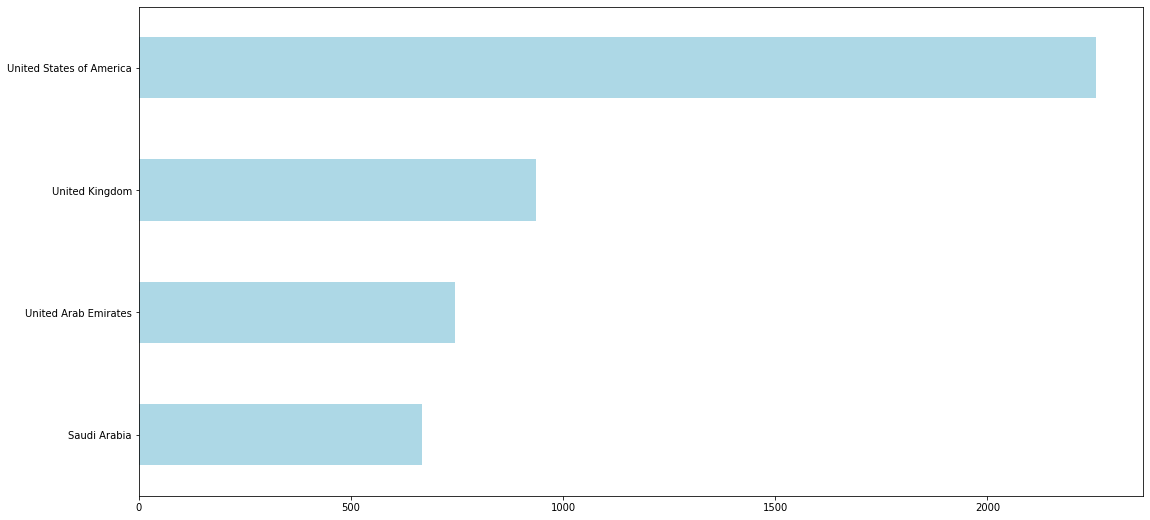

In [ ]:
chiboxing(dummifier(data.reviewer_nationality), 500)

У нас наблюдаются две значимые группы ревьюеров: "Англосаксы" и "Арабы". Посмотрим как они, а также граждане иных государств оценивают отели в разных странах. Построим тепловую диаграмму типа страна-рецензент, для государств, граждане которых оставили более 0.05% отзывов(значение порога выбрано с учётом удобства визуализации).

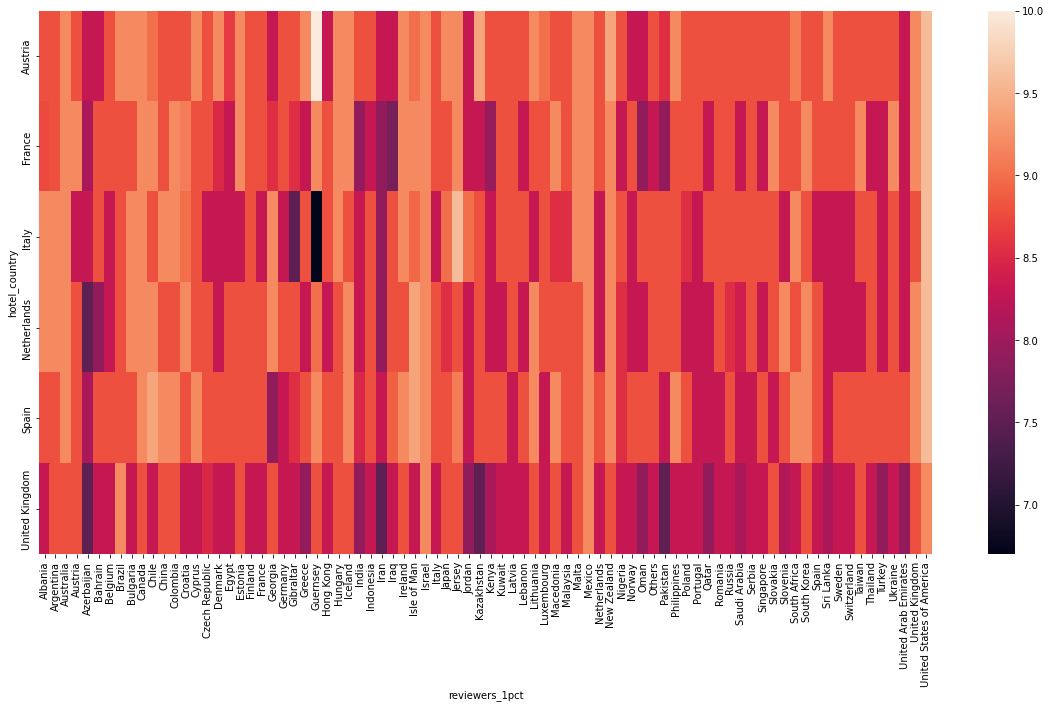

In [ ]:
reviewers_1pct=data.reviewer_nationality.value_counts()[data.reviewer_nationality.value_counts(True)*100>0.05].index
data['reviewers_1pct']=data['reviewer_nationality'].apply(lambda x:  x if x in reviewers_1pct else 'Others')
data['reviewers_1pct']

plt.figure(figsize=[20, 10])
hot_rev_pivot=data.query('sample==1').pivot_table(index='hotel_country', columns='reviewers_1pct', values='reviewer_score', aggfunc='median')
sns.heatmap(hot_rev_pivot)

Согласно диаграмме, самый низкий уровень оценок наблюдается для отелей Великобритании и Италии, a самый позитивный для отелей Австрии и Испании. Обращает на себя внимание сходные паттерны голосования у следующших групп рецензентов:

1) Саудовская Аравия, Турция, ОАЭ. Самые низкие оценки

2) США, Мексика, Израиль, Австралия,Новая Зеландия а также Великобритания, Ирландия, Исландия и Канада- самые высокие оценки (особенно у США).

Создадим параметр принадлежности страны рецензента к мусульманским странам (К ним же добавим выходцев из Индии, обладающих схожим поведением).

Аналогичный групповой признак мы зададим для стран с преобладающим англосаксонским этническим компонентом (условно назовём их WASP), Израиля и Мексики.

reviewers_WASP&IL           2284.354
high_demanding_muslims&IN   2936.228
dtype: float64

['reviewers_WASP&IL', 'high_demanding_muslims&IN']

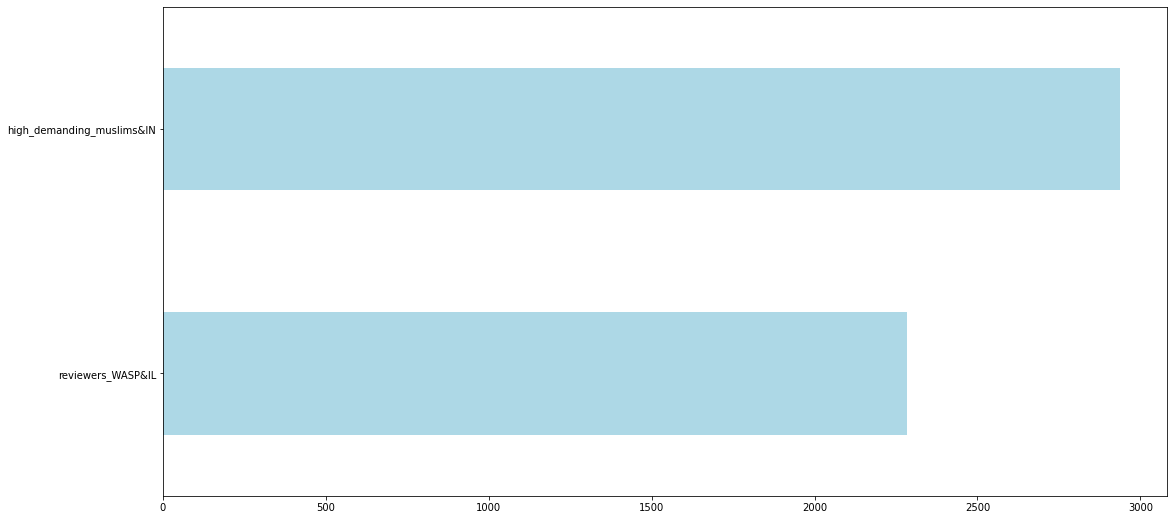

In [ ]:
islamic_countries=['United Arab Emirates','Turkey', 'Azerbaijan', 'Saudi Arabia', "Iran", "Pakistan", 'Egypt', 'Morocco',
                   'Lebanon',  'Bangladesh', 'Syria',  'Kuwait',   'Qatar', 'Jordan', 'Oman', 'Bahrain',  'India']

data['high_demanding_muslims&IN']=np.where(data.reviewer_nationality.isin(islamic_countries), True, False)

data['reviewers_WASP&IL']=np.where(data['reviewers_1pct'].isin(['United Kingdom', 'United States of America',
                                                                'Israel', 'Australia',"Canada", 'New Zealand', 'Mexico']), True, False)

chiboxing(data[['high_demanding_muslims&IN', 'reviewers_WASP&IL']], 500)

Первый признак выглядит более сильным чем последующий

Продолжим анализ признака с рассмотрением стран с точки зрения их принадлежности к:

1) континентам

2) регионам по классификации ООН

3) международным организациям.

Почистим данные, относя локации рецензентов из непризнанных государств к крупным странам.

In [ ]:
data.loc[data['reviewer_nationality']=="Kosovo", 'reviewer_nationality']="Serbia"
data.loc[data['reviewer_nationality']=="Abkhazia Georgia", 'reviewer_nationality']="Georgia"
data.loc[data['reviewer_nationality']=="Cura ao", 'reviewer_nationality']="Netherlands"
data.loc[data['reviewer_nationality']=='U S Virgin Islands', 'reviewer_nationality']="United States of America"
data.loc[data['reviewer_nationality']=='Palestinian Territory', 'reviewer_nationality']="Palestine"
data.loc[data['reviewer_nationality']=='Falkland Islands Malvinas', 'reviewer_nationality']="Argentina"
data.loc[data['reviewer_nationality']=='Turks Caicos Islands', 'reviewer_nationality']="United Kingdom"
data.loc[data['reviewer_nationality']=='Crimea', 'reviewer_nationality']="Russia"
data.loc[data['reviewer_nationality']=='St Maarten', 'reviewer_nationality']="Netherlands"
data.loc[data['reviewer_nationality']=='Antigua Barbuda', 'reviewer_nationality']="United Kingdom"
data.loc[data['reviewer_nationality']=='St Pierre and Miquelon', 'reviewer_nationality']="France"
data.loc[data['reviewer_nationality']==('Cocos K I' or 'Keeling'), 'reviewer_nationality']="Australia"
data.loc[data['reviewer_nationality']=='Saint Vincent Grenadines', 'reviewer_nationality']="United Kingdom"
data.loc[data['reviewer_nationality']=='Reunion', 'reviewer_nationality']="France"
data.loc[data['reviewer_nationality']=='Bonaire St Eustatius and Saba', 'reviewer_nationality']="Netherlands"
data.loc[data['reviewer_nationality']=='Svalbard Jan Mayen', 'reviewer_nationality']="Norway"
data.loc[data['reviewer_nationality']=='Saint Barts', 'reviewer_nationality']="France"
data.loc[data['reviewer_nationality']=='Central Africa Republic', 'reviewer_nationality']="Central African Republic"
data.loc[data['reviewer_nationality']=='Central Africa Republic', 'reviewer_nationality']="Central African Republic"
data.loc[data['reviewer_nationality']=='Vatican City', 'reviewer_nationality']="Italy"

Создаём служебную колонку кодов стран по ISO 3166-1 alpha-2

In [ ]:
data['country_abb']=data.reviewer_nationality.apply(lambda x:
                                                        pc.country_name_to_country_alpha2(x,
                                                                                          cn_name_format="default"))

data[['country_abb']].head(10).T

,0,1,2,3,4,5,6,7,8,9
country_abb,GB,BE,SE,US,GB,EC,GB,NL,IE,CA


Заменяем аббревиатуры согласно требованию функции country_alpha2_to_continent_code, и создаём признак континентов. Посчитаем меры центральной тенденции по континетам для показателей average_score и reviewer_score(для обучающей выборки).

In [ ]:
data['country_abb'].replace('UM', "US", inplace=True)
data['country_abb'].replace('AQ', "GB", inplace=True)
data['country_abb'].replace('TL', "ID", inplace=True) #Eastern Timoir is close to Indonesia so we will use Indonesia code


data['continent_name'] = data['country_abb'].apply(lambda x: pc.country_alpha2_to_continent_code(x))

(data['continent_name'].value_counts(normalize=True)*100).round(0).astype(int)
data.groupby(['continent_name']).average_score.mean().round(1)

continent_name
AF   8.300
AS   8.400
EU   8.400
NA   8.500
OC   8.500
SA   8.400
Name: average_score, dtype: float64

In [ ]:
data.query('sample==1').groupby(['continent_name']).reviewer_score.agg(['median', 'mean']).round(1)

,median,mean
continent_name,,
AF,8.800,8.200
AS,8.300,8.100
EU,8.800,8.400
NA,9.200,8.700
OC,9.200,8.600
SA,8.800,8.400


Северная Америка и Океания выглядят значительно благожелательнее в своих оценках. Создадим новый признак - нахождение рецензента в Северной Америке или Океании и проверим, не коррелирует ли она с признаком 'reviewers_WASP&IL'. Уровень корреляции невысокий, мы оставляем оба признака.

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


NAOC   1943.284
dtype: float64

['NAOC']

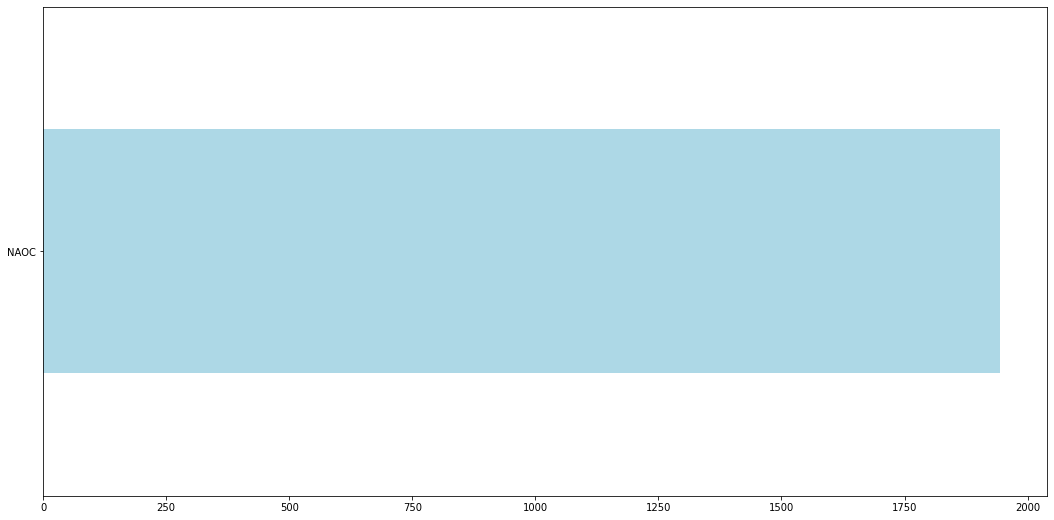

In [ ]:
data['NAOC']=np.where(data['continent_name'].isin(['OC', 'NA']), True, False)
data['NAOC'].corr(data['reviewers_WASP&IL'], 'kendall')
chiboxing(data['NAOC'], 500)

In [ ]:
# data.drop(['av_top_100_hotels_list', 'international', 'hotel_name_tok', 'hotel_name_words_', 'tara',
#                    'hotel_other_words', 'hotel_nametext_string_fdist', 'hotel_addresstext_string_fdist', 'hotel_address_tok',
#        'hotel_address_words_', 'hotel_addresstext_string_lem', 'lng', 'lat', 'grand'], axis=1,
#          inplace=True)

Посмотрим, наблюдается ли какая-то связь между нахождением страны рецензента в какой-либо международной организации политического либо экономического профиля. Для этого преобразуем reviewer_nationality в формат в формат аббревиатур согласно alpha3 с которым работает библиотека country_converter и обработаем признак имеющимися методами.

In [ ]:
data['country_abb_alpha3']=data.reviewer_nationality.apply(lambda x:
                                                        pc.country_name_to_country_alpha3(x,
                                                                                          cn_name_format="default"))
data['country_abb_alpha3'].head(3)

0    GBR
1    BEL
2    SWE
Name: country_abb_alpha3, dtype: object

In [ ]:
# import country_converter as coco
converter = coco.CountryConverter()
country_list_alpha3=data['country_abb_alpha3'].unique()

In [ ]:
UNregion_list=converter.convert(names = country_list_alpha3, src = 'ISO3', to = 'UNregion')
UNregion_dict=dict(zip(country_list_alpha3, UNregion_list))
data['reviewers_UNregion']=data['country_abb_alpha3'].map(UNregion_dict)
data['reviewers_UNregion'].nunique()

23

In [ ]:
data['reviewers_UNregion'].value_counts(False)

Northern Europe              274894
Western Asia                  47493
Northern America              43451
Western Europe                42825
Australia and New Zealand     24925
Southern Europe               22567
Eastern Europe                19464
Eastern Asia                   9859
South-Eastern Asia             9809
Southern Asia                  5952
Southern Africa                3941
South America                  3413
Northern Africa                2916
Western Africa                 1209
Central America                 956
Eastern Africa                  810
Caribbean                       663
Central Asia                    343
Middle Africa                    95
Micronesia                       92
Melanesia                        44
Polynesia                        14
Antarctica                        3
Name: reviewers_UNregion, dtype: int64

Мы получили разнесение рецензентов по регионам земного шара. Проверим какие локации могут влиять на отзывы

Southern Asia       555.135
Northern Europe     696.111
Western Europe     1236.667
Western Asia       1644.895
Northern America   2042.182
dtype: float64

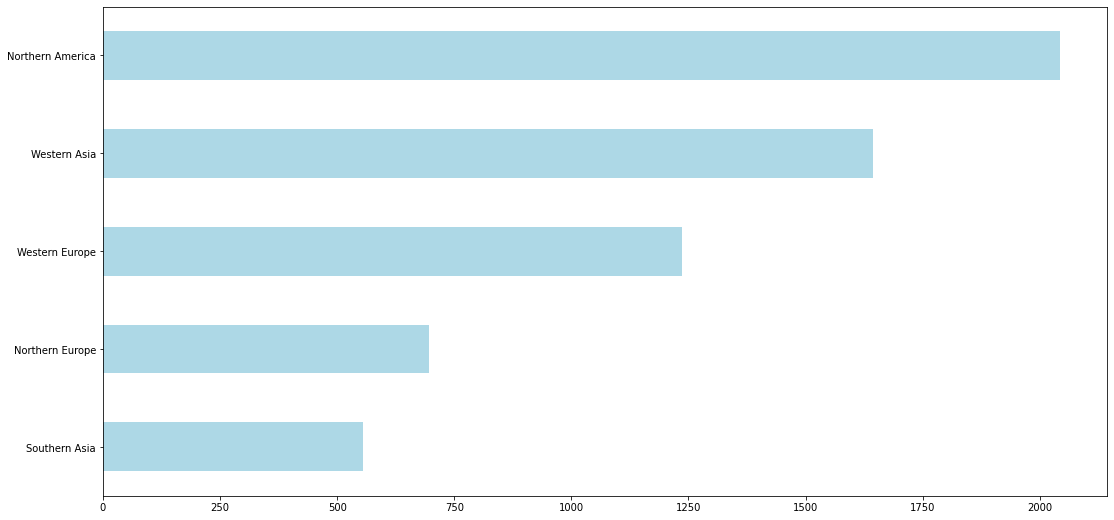

In [ ]:
unreglist=chiboxing(dummifier(data['reviewers_UNregion']), 500)

Итак, значимо влияют Северная Америка, Западная и Северная Европа, а также Передняя Азия, в наименьшей степени Южная Азия

In [ ]:
reg_frame=bin_creator(unreglist, data.reviewers_UNregion, "r", "_reg")[0]

А как насчёт влияния на оценки принадлежности к Евросоюзу?

In [ ]:
EU_list=converter.convert(names = country_list_alpha3, src = 'ISO3', to = 'EU')
EU_dict=dict(zip(country_list_alpha3, EU_list))
data['reviewers_EU_residence']=data['country_abb_alpha3'].map(EU_dict)
data['reviewers_EU_residence']=np.where(data['reviewers_EU_residence']=='EU', 1, 0)

reviewers_EU_residence   1376.595
dtype: float64

['reviewers_EU_residence']

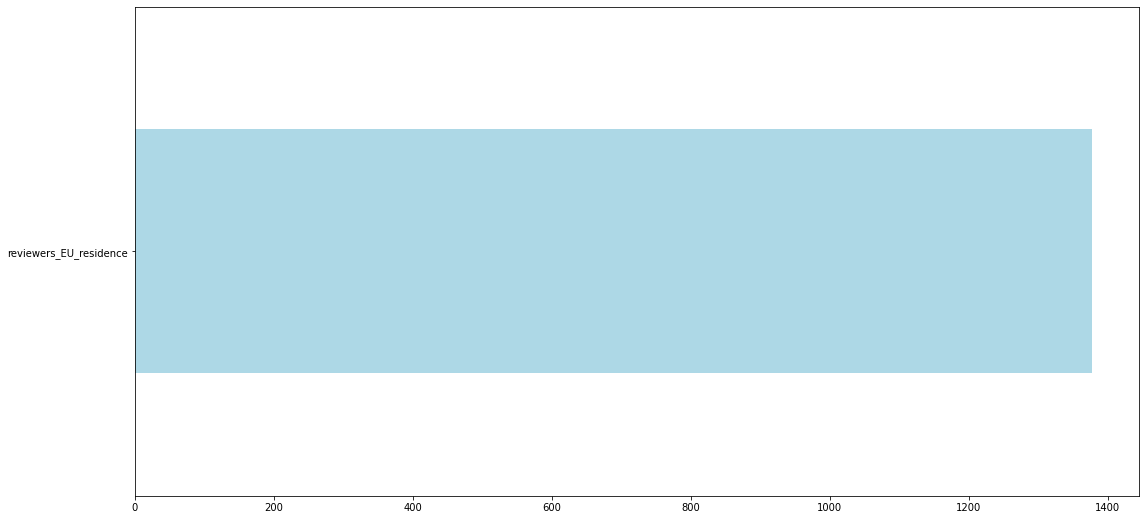

In [ ]:
chiboxing(data['reviewers_EU_residence'], 500)

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


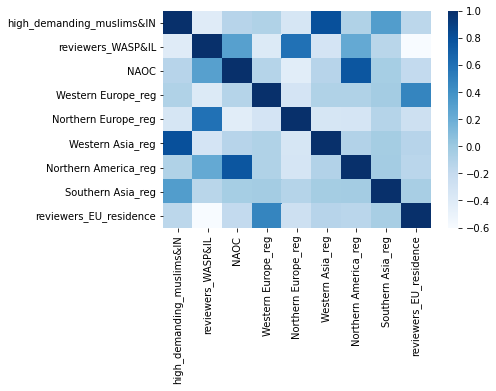

In [ ]:
sns.heatmap(data[['high_demanding_muslims&IN', 'reviewers_WASP&IL',
       'country_abb', 'continent_name', 'NAOC', 'country_abb_alpha3',
       'reviewers_UNregion', 'Western Europe_reg', 'Northern Europe_reg',
       'Western Asia_reg', 'Northern America_reg', 'Southern Asia_reg',
       'reviewers_EU_residence']].select_dtypes(exclude='object').corr('kendall'), cmap='Blues')

Итак, признак Western Asia ожидаемо высоко коррелирован с High demanding muslim (соответствующая первая общность является подмножеством второй) и исключается из рассмотрения. European EU residents в основном принадлежат к  Western_Europe, связь с Северной Европой и Великобританией минимальная. Удаляем Western_Europe как более слабый признак.  Также, не выдержав сравнения с признаком NAOC у нас уходит признак Nothern America, здесь видимо тоже сказывается усиление первого признака идентичным поведением Австралии и Океании. Признак Nothern Europe сильно коррелирует с признаком WASP&IL.

Региональные признаки ничего не дали нам с точки зрения модели, но позволили:

1) уточнить ситуацию с США, которые одновременно входят и кластер североамерикано-североевропейско-израильской общности и в кластер Северная Америка-Океания.

2) обнаружить различия в оценках представителей Западной и Северной Европы


In [ ]:
featdropper(data, ['Western Asia_reg', 'Northern America_reg', 'Northern Europe_reg'])

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'tags',
       'days_since_review', 'lat', 'lng', 'sample', 'reviewer_score',
       'hotel_name_tok', 'hotel_name_words_', 'hotel_nametext_string_fdist',
       'hotel_nametext_string_lem', 'best_western', 'holiday inn',
       'kensington', 'park', 'paddington', 'Grand Royale London Hyde Park',
       'The Cumberland A Guoman Hotel',
       'BEST WESTERN Maitrise Hotel Maida Vale',
       'Holiday Inn London Kensington', 'NH Carlton Amsterdam',
       'Shaftesbury Premier London Paddington', 'Park Lane Mews Hotel',
       'Hyatt Regency Paris Etoile', 'Gainsborough Hotel', 'Henry VIII',
       'Hilton London Metropole', 'Bloomsbury Palace Hotel

#### **4) tags**

Теперь посмотрим, можно ли извлечь каую-то пользу из информации содержащейся в признаке tag. Тэги упорядочены, но количество их в строке непостоянно, что затруднёет обработку.Для первой  разбивки на подстолбцы будем использовать слово nights, встречающееся в каждой строке. Далее извлечём признак количества ночей и продолжим разбиения.

In [ ]:
tags_list=data.tags.str.lower().str.split()
tags_list



0                                                                                [[', leisure, trip, ',, ', couple, ',, ', double, room, ',, ', stayed, 2, nights, ']]
1                                                                                  [[', leisure, trip, ',, ', group, ',, ', triple, room, ',, ', stayed, 1, night, ']]
2                               [[', business, trip, ',, ', solo, traveler, ',, ', twin, room, ',, ', stayed, 1, night, ',, ', submitted, from, a, mobile, device, ']]
3                                                                    [[', leisure, trip, ',, ', couple, ',, ', ambassador, junior, suite, ',, ', stayed, 1, night, ']]
4         [[', business, trip, ',, ', solo, traveler, ',, ', classic, double, or, twin, room, ',, ', stayed, 2, nights, ',, ', submitted, from, a, mobile, device, ']]
                                                                                      ...                                                                            

0   2.000
1   1.000
2   1.000
3   1.000
4   2.000
Name: nights, dtype: float64

nights   435.918
dtype: float64

['nights']

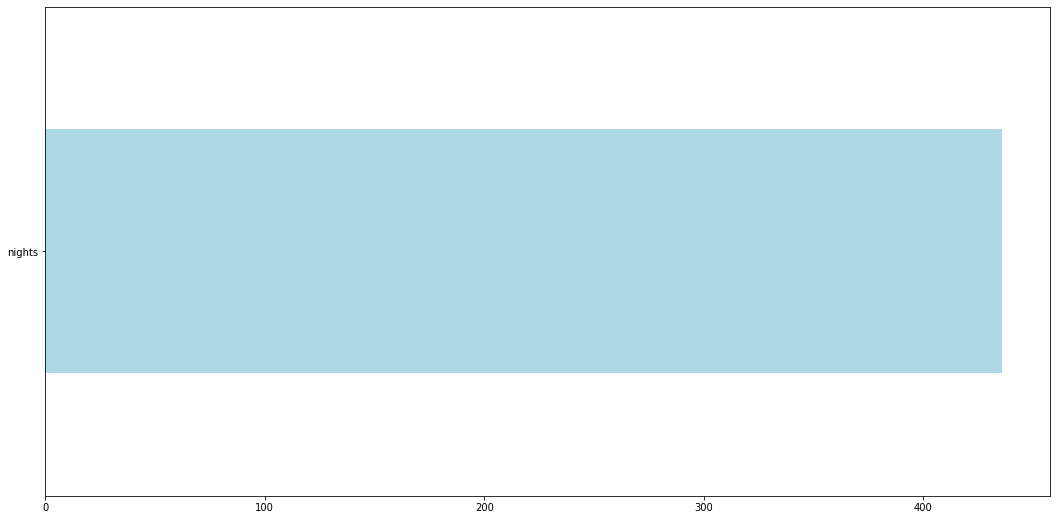

In [ ]:
data['nights']=data['tags'].str.split(pat='Stayed',
                                      expand=True)[1].str.split(pat='nights|night', expand=True)[0]

data['nights']=pd.to_numeric(data['nights'])
display(data['nights'].head())
data['nights'].fillna(1, inplace=True)
chiboxing(data['nights'], 10)

Значимость признака низкая, исключаем его из рассмотрения

Продолжая разбиения извлекаем признак назначения поездки и  признак сочетания состава группы путешествующих и занимаемого ими типа номера

In [ ]:
travel_mode_and_room=data['tags'].str.split(pat='Stayed',
                                      expand=True)[0].str.split(pat='nights|night', expand=True)[0].str.split(',', n=1, expand=True)
                                      # .iloc[:, :3]

In [ ]:
travel_mode_and_room[1].str.strip("''").str.split(',', expand=True).drop([2, 3], axis=1, inplace=True)

Leisure trip    1009.558
Business trip   4195.953
dtype: float64

['Leisure trip', 'Business trip']

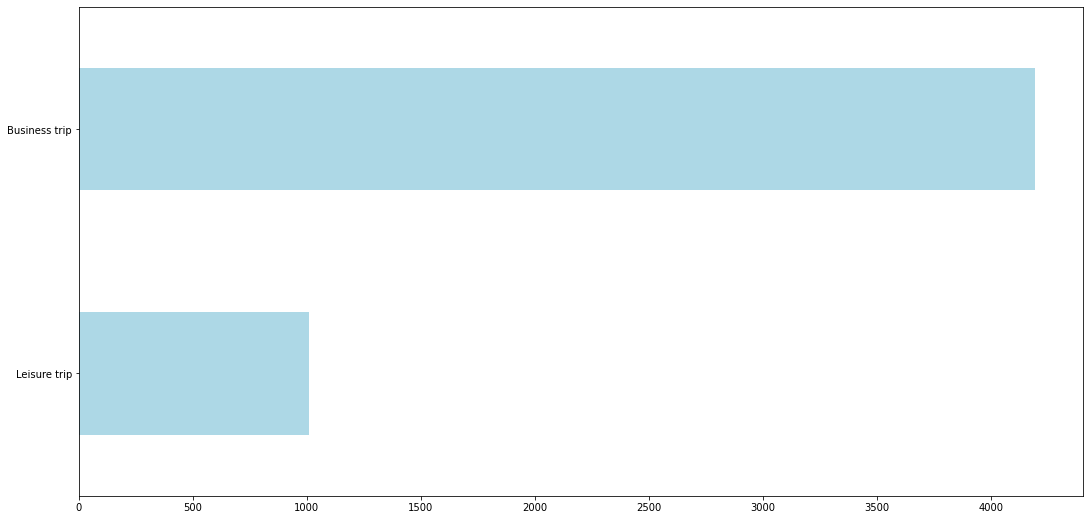

In [ ]:
travel_mode_and_room=travel_mode_and_room.apply(lambda x:x.str.strip().str.strip("[").str.strip("' "))
chiboxing(dummifier(travel_mode_and_room[0]), 500)

Значимы только 2 класса назначений поездок:' Business trip 'и ' Leisure trip ' но они имеют высочайший уровень отрицательной корреляции. Поэтому мы выбираем признак ' Business trip ', имеющий чуть меньшую значимость

In [ ]:
data['Business trip']=np.where(data.tags.str.contains('Business trip'), True, False)
data['Leisure trip']=np.where(data.tags.str.contains('Leisure trip'), True, False)
data[['Leisure trip', 'Business trip']].corr()

,Leisure trip,Business trip
Leisure trip,1.000,-0.904
Business trip,-0.904,1.000


In [ ]:
featdropper(data, 'Leisure trip' )

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'tags',
       'days_since_review', 'lat', 'lng', 'sample', 'reviewer_score',
       'hotel_name_tok', 'hotel_name_words_', 'hotel_nametext_string_fdist',
       'hotel_nametext_string_lem', 'best_western', 'holiday inn',
       'kensington', 'park', 'paddington', 'Grand Royale London Hyde Park',
       'The Cumberland A Guoman Hotel',
       'BEST WESTERN Maitrise Hotel Maida Vale',
       'Holiday Inn London Kensington', 'NH Carlton Amsterdam',
       'Shaftesbury Premier London Paddington', 'Park Lane Mews Hotel',
       'Hyatt Regency Paris Etoile', 'Gainsborough Hotel', 'Henry VIII',
       'Hilton London Metropole', 'Bloomsbury Palace Hotel

Рассмотрим теперь составной признак "состав-номер". для удобства создадим облако тэгов

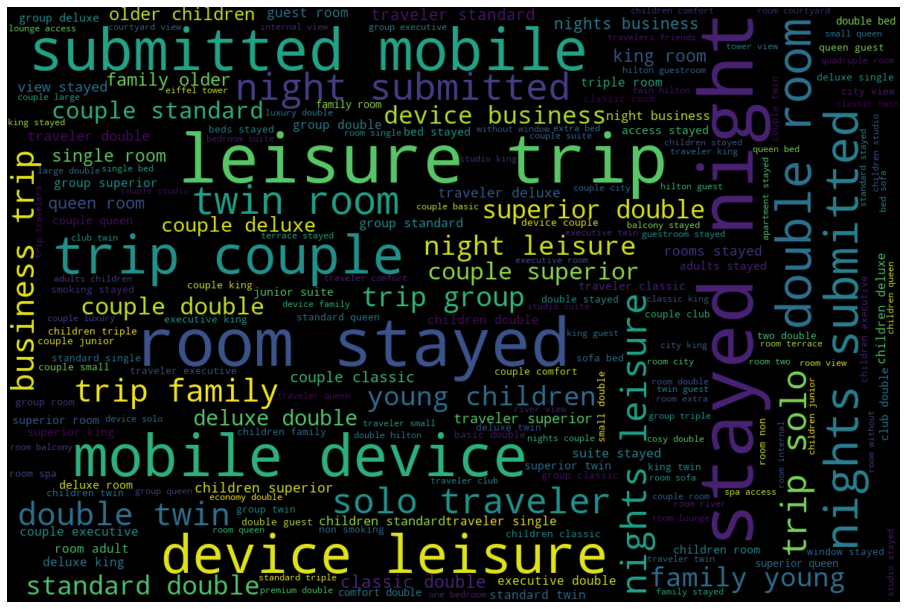

In [ ]:
tags_list=nltkzer(data, 'tags', stopwords)

In [ ]:
tag_wordfreq=pd.DataFrame([tags_list]).T.rename(columns={0:"Freq"})
tag_wordfreq.sort_values('Freq', ascending=False, inplace=True)
display(tag_wordfreq.head(25))

,Freq
stayed,515546
trip,500717
room,467443
leisure,417900
nights,321909
mobile,307693
device,307640
submitted,307640
double,305322
couple,252294


In [ ]:
# tags_list
# data=pd.concat([data, bin_creator(tags_list, data.tags)[0]], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Couple ', ' Standard Double Room without Window ',   566.023
dtype: float64

["Couple ', ' Standard Double Room without Window ',"]

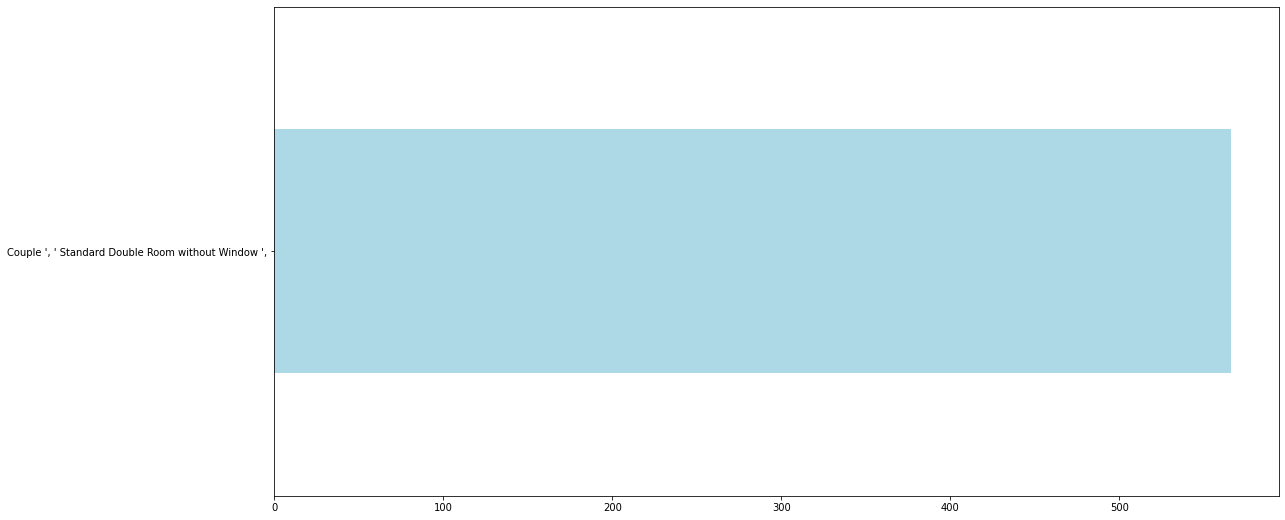

In [ ]:
pop_rooms_and_members_list=travel_mode_and_room[1].value_counts().nlargest(100).index
chiboxing(bin_creator(pop_rooms_and_members_list, data.tags)[0], 500)
#  Высокие вычислительные затраты и риск сбоя,
# приведениы полученные значения

Standard Double Room without Window   1347.101
dtype: float64

['Standard Double Room without Window']

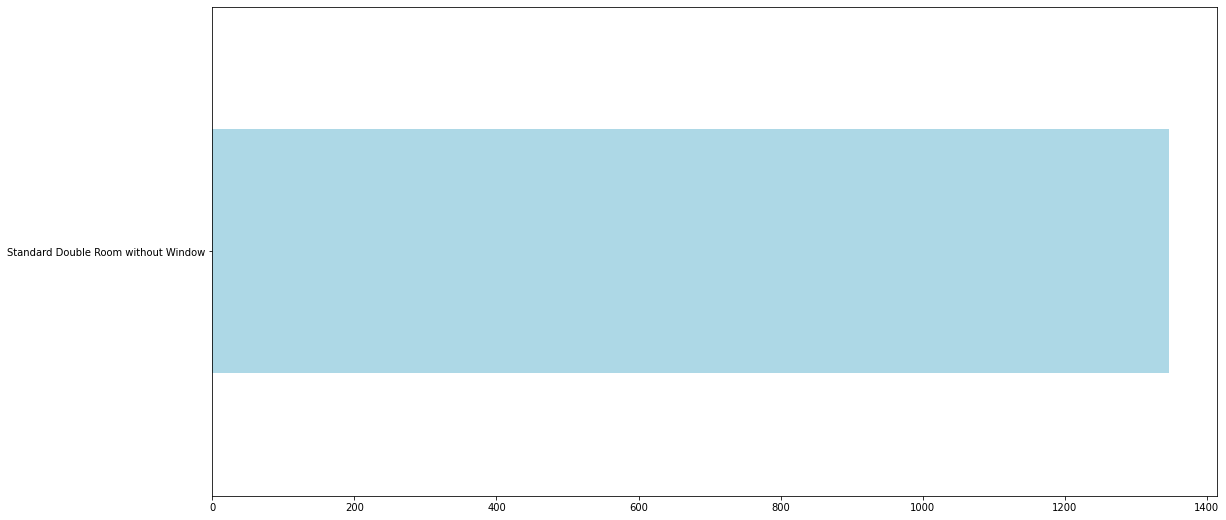

In [ ]:
data['Standard Double Room without Window']=np.where(data.tags.str.contains('Standard Double Room without Window'), True, False)
chiboxing(data['Standard Double Room without Window'], 500)

Продолжаем анализ признака и доизвлекаем из него оставшийся признак отправки отзыва по мобильному телефону.

mobile_review   625.487
dtype: float64

['mobile_review']

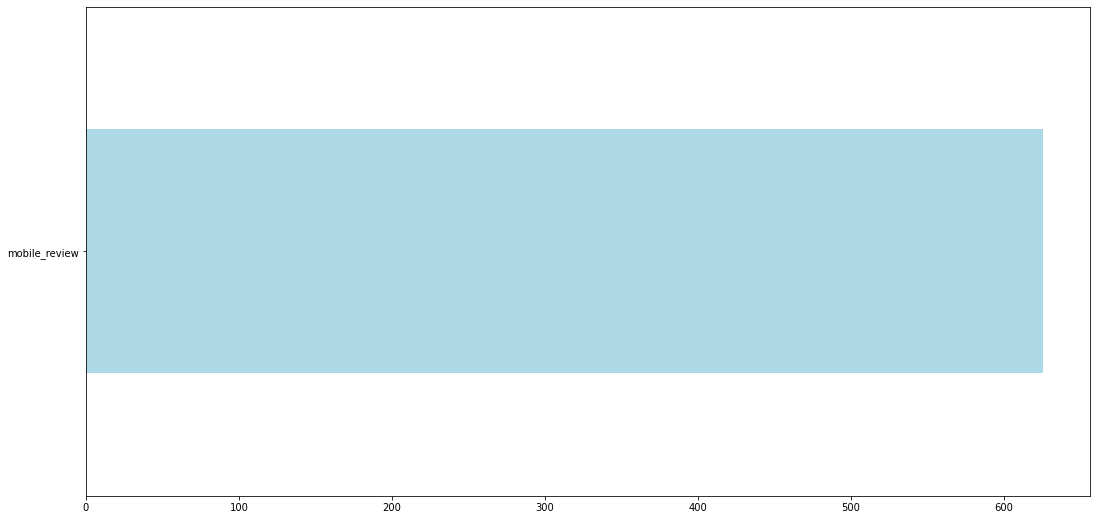

In [ ]:
data['tags'].str.split(pat='Stayed',
                                      expand=True)[1].str.split(pat='nights|night', expand=True)[1].value_counts()

                                      # [:].str.split(',', n=1, expand=True).head(5)
data['mobile_review']=np.where(data.tags.str.contains('Submitted from a mobile device'), True, False)
chiboxing(data['mobile_review'])

отбираем этот признак для модели.

#### **5A) Negative_review**

Переходим к анализу отзывов.

In [ ]:
data['negative_review'].head(2)

0    Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices
1                                                                                                                                                                                                                             No tissue paper box was present at the room
Name: negative_review, dtype: object

В первом приближении попробуем извлечь признаки вручную (в данной версии мы изучаем что может дать нам датасет бех применения билиотек анализа тональности высказований). Для начала посмотрим на облако тэгов.


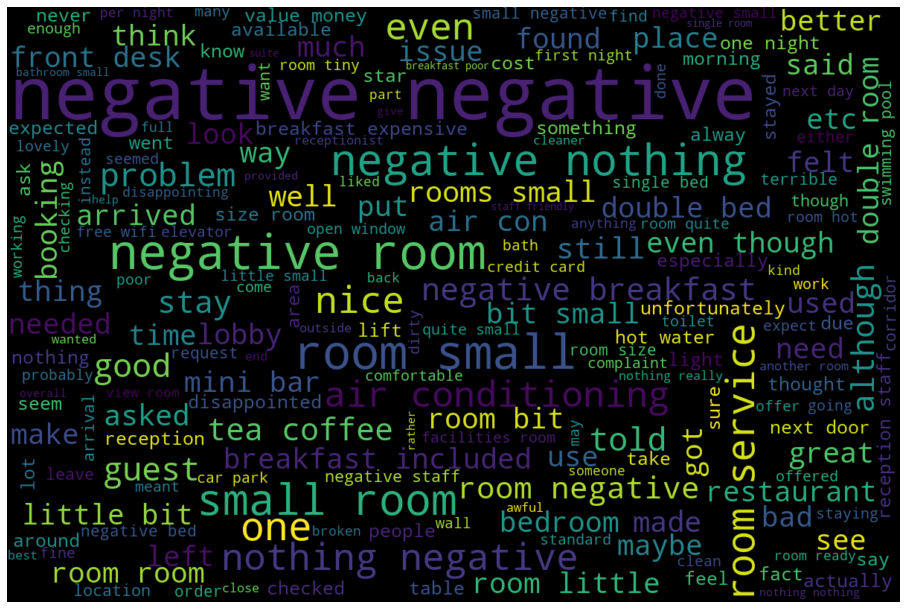

In [ ]:
neg_words=nltkzer(data, 'negative_review', stopwords)

In [ ]:
neg_wordfreq=pd.DataFrame([neg_words]).T.rename(columns={0:"Freq"})
neg_wordfreq.sort_values('Freq', ascending=False, inplace=True)
display(neg_wordfreq.head(25))

,Freq
room,176026
negative,129447
breakfast,58478
small,49880
staff,39512
nothing,38768
rooms,34802
would,32291
could,32079
bed,29828


Проведём автоматический поиск значимых слов. Порог отсечения увеличим до 3000 (чтобы не выбрать избыточное количество слов и не создать предпосылки для возникновения мультиколлинеарности),  а глубину поиска ограничим семьюстами самыми распространёнными в отзывах словами.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


ask          7584.708
thin         7670.686
check        7777.210
air          7915.884
work         8131.652
bath         8141.001
ever         8375.150
per          8394.119
even         8448.120
use          8558.176
end          8638.301
rude         8658.877
night        8672.394
book         8917.909
able         9256.338
reception    9529.444
poor         9916.327
thing        9992.732
clean       10619.720
rooms       10743.816
con         11077.667
star        11488.538
dirty       12290.963
small       12416.037
bed         12546.210
com         12967.269
one         13798.302
old         15522.207
staff       16878.911
hot         19620.092
room        35799.420
dtype: float64

['ask',
 'thin',
 'check',
 'air',
 'work',
 'bath',
 'ever',
 'per',
 'even',
 'use',
 'end',
 'rude',
 'night',
 'book',
 'able',
 'reception',
 'poor',
 'thing',
 'clean',
 'rooms',
 'con',
 'star',
 'dirty',
 'small',
 'bed',
 'com',
 'one',
 'old',
 'staff',
 'hot',
 'room']

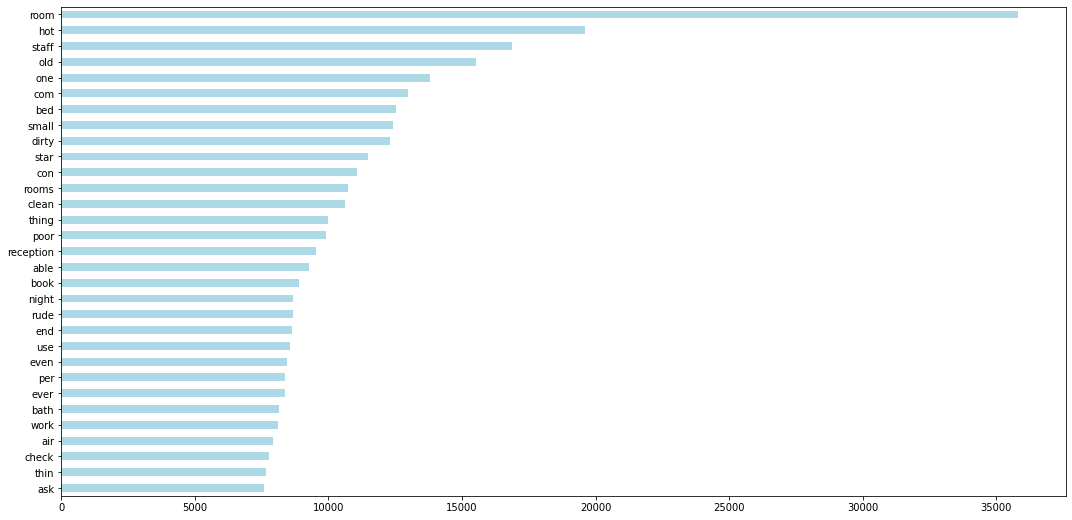

In [ ]:
top1000negwords=list(neg_wordfreq.nlargest(500, 'Freq').index)
chiboxing(bin_creator(top1000negwords, data.negative_review)[0], 7500)

Создадим признаки из этих и подобранных вручную слов.

neg_sure          1143.162
neg_nothing       1219.859
neg_out of        1459.997
neg_tea           1550.342
neg_travel        1584.979
neg_view          1609.218
neg_far           1804.006
neg_without       3037.456
neg_noisy         3742.503
neg_breakfast     4042.392
neg_feelings      4445.993
neg_other         5328.127
neg_help          5385.906
neg_smell         5601.970
neg_wait          7133.717
neg_service       7180.943
neg_stay          7392.124
neg_condition     8887.117
neg_unfriendly   10538.954
neg_spoiled      10676.456
neg_renovation   10926.541
neg_price        11613.401
neg_star         11800.912
neg_could        12652.335
neg_never        13171.603
neg_bathroom     13756.016
neg_old          15522.207
neg_very         16871.151
neg_questions    17664.299
neg_dirty        18128.583
neg_bad          18413.475
neg_hot          19100.795
neg_not          20183.112
neg_staff        20863.768
neg_reception    21862.394
neg_small room   35799.420
neg_negative     38856.079
d

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


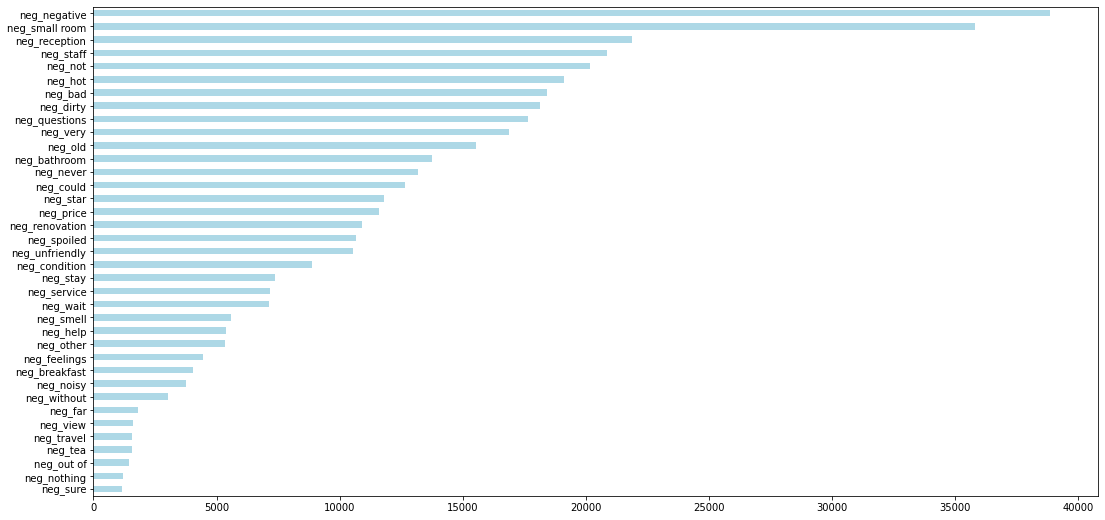

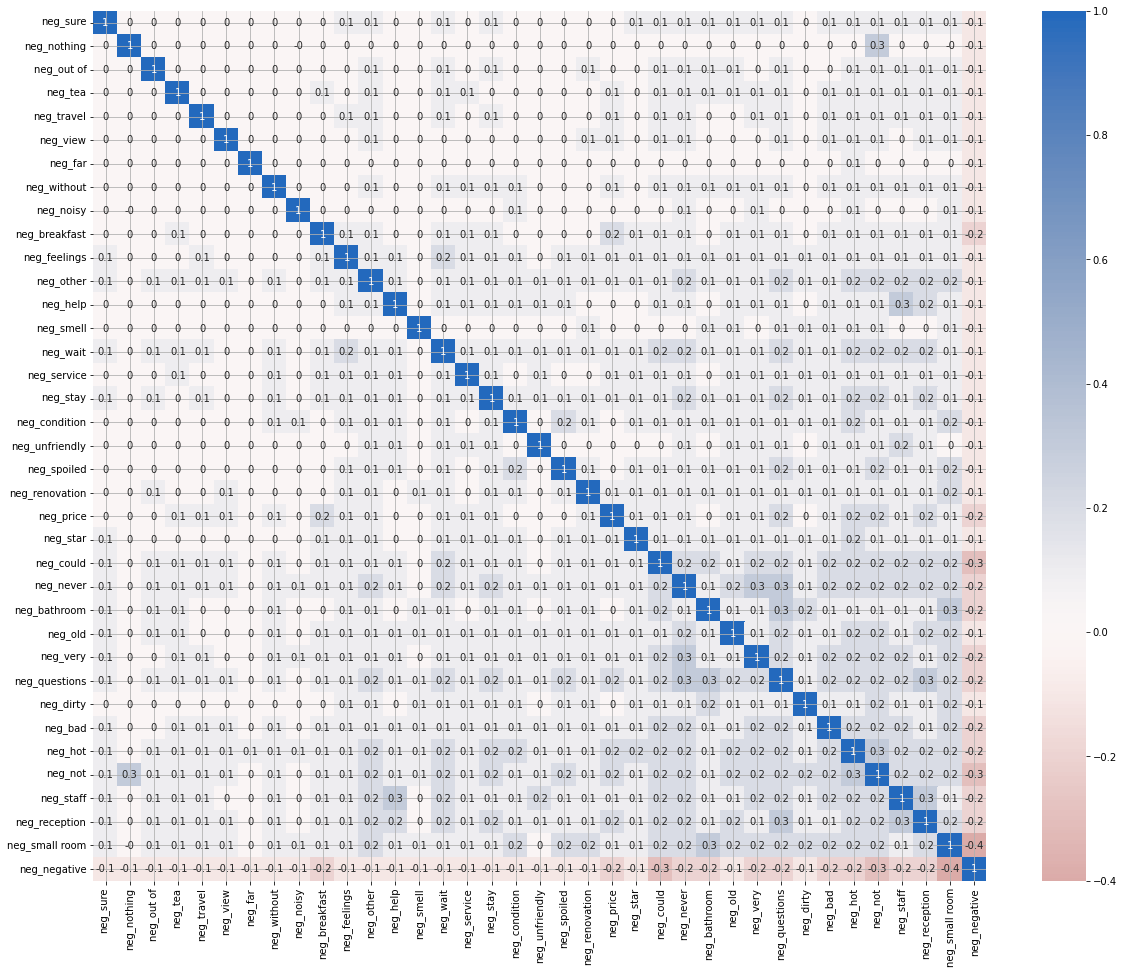

In [ ]:
data['neg_other']=np.where(data['negative_review'].str.lower().str.contains('other'), True, False)
data['neg_star']=np.where(data['negative_review'].str.lower().str.contains('star'), True, False)
data['neg_smell']=np.where(data['negative_review'].str.lower().str.contains('smell'), True, False)
data['neg_reception']=np.where(data['negative_review'].str.lower().str.contains('reception|book|check|desk'), True, False)
data['neg_travel']=np.where(data['negative_review'].str.lower().str.contains('travel'), True, False)
data['neg_sure']=np.where(data['negative_review'].str.lower().str.contains('sure'), True, False)
data['neg_without']=np.where(data['negative_review'].str.lower().str.contains('without|absent|missing'), True, False)
data['neg_could']=np.where(data['negative_review'].str.lower().str.contains('could|should|able|need'), True, False)
data['neg_negative']=np.where(data['negative_review'].str.lower().str.contains('no negative'), True, False)
data['neg_small room']=np.where(data['negative_review'].str.contains(('small|little|tiny' ) and 'room'), True, False)
data['neg_very']=np.where(data['negative_review'].str.contains('very'), True, False)
data['neg_dirty']=np.where(data['negative_review'].str.contains('dirty|dusty|clean'), True, False)
data['neg_nothing']=np.where(data['negative_review'].str.contains('nothing'), True, False)
data['neg_not']=np.where(data['negative_review'].str.contains('not'), True, False)
data['neg_noisy']=np.where(data['negative_review'].str.contains('noisy'), True, False)
data['neg_unfriendly']=np.where(data['negative_review'].str.contains('unfriendly|unkind|disrespectful|rude'), True, False)
data['neg_breakfast']=np.where(data['negative_review'].str.contains('breakfast'), True, False)
data['neg_tea']=np.where(data['negative_review'].str.contains('tea'), True, False)
data['neg_bathroom']=np.where(data['negative_review'].str.contains('bath|toilet|shower|water'), True, False)
data['neg_staff']=np.where(data['negative_review'].str.contains('staff|personnel|employ|girl]boy|woman|man|lady'), True, False)
data['neg_wait']=np.where(data['negative_review'].str.contains('wait|time'), True, False)
data['neg_bad']=np.where(data['negative_review'].str.contains('bad|worst|well|good|poor|proper|low|terrible'), True, False)
data['neg_out of']=np.where(data['negative_review'].str.contains('out of'), True, False)
data['neg_never']=np.where(data['negative_review'].str.contains('ever|again|return|back|next'), True, False)
data['neg_help']=np.where(data['negative_review'].str.contains('help|assist'), True, False)
data['neg_hot']=np.where(data['negative_review'].str.contains('hot|warm'), True, False)
data['neg_spoiled']=np.where(data['negative_review'].str.contains('spoiled|operation|broken|work'), True, False)
data['neg_renovation']=np.where(data['negative_review'].str.contains('renovation|look|wall|carpet'), True, False)
data['neg_old']=np.where(data['negative_review'].str.contains('old'), True, False)
data['neg_condition']=np.where(data['negative_review'].str.contains('condition|air'), True, False)
data['neg_stay']=np.where(data['negative_review'].str.contains('stay'), True, False)
data['neg_park']=np.where(data['negative_review'].str.contains('park'), True, False)
data['neg_far']=np.where(data['negative_review'].str.contains('far|distant'), True, False)
data['neg_view']=np.where(data['negative_review'].str.contains('view'), True, False)
data['neg_price']=np.where(data['negative_review'].str.contains('price|cost|money|pay|paied'), True, False)
data['neg_window']=np.where(data['negative_review'].str.contains('window|door'), True, False)
data['neg_bed']=np.where(data['negative_review'].str.contains('bed|sleep|blanket|pillow'), True, False)
data['neg_service']=np.where(data['negative_review'].str.contains('service'), True, False)
data['neg_questions']=np.where(data['negative_review'].str.contains('why|who|where|how|when|what'), True, False)
data['neg_want']=np.where(data['negative_review'].str.contains('want|do|need'), True, False)
data['neg_dark']=np.where(data['negative_review'].str.contains('dark|light|dim|gloom'), True, False)
data['neg_advice']=np.where(data['negative_review'].str.contains('advi|recommend'), True, False)
data['neg_information']=np.where(data['negative_review'].str.contains('inform|ask'), True, False)
data['neg_feelings']=np.where(data['negative_review'].str.contains('angr|disgust|sad|rage|lon|annoy|bor'), True, False)
data['neg_bad_word']=np.where(data['negative_review'].str.contains('stupid|idiot|fool|crazy|mad'), True, False)


neg_word_list=['neg_negative', 'neg_small room', 'neg_nothing', 'neg_not', 'neg_noisy', 'neg_very', 'neg_unfriendly',
               'neg_breakfast', 'neg_tea', 'neg_staff', 'neg_wait', 'neg_bad', 'neg_out of', 'neg_never', 'neg_hot',
               'neg_old', 'neg_spoiled','neg_dirty','neg_bathroom', 'neg_condition', 'neg_questions','neg_reception',
               'neg_renovation', 'neg_help', 'neg_stay', 'neg_far', 'neg_view', 'neg_price', 'neg_service',
               'neg_feelings', 'neg_sure', 'neg_travel', 'neg_could', 'neg_without', 'neg_other', 'neg_star',
               'neg_smell']



neg_words_man=chiboxing(data[neg_word_list])

plt.figure(figsize=(20, 16))
sns.heatmap(data[neg_words_man].corr("kendall").round(1),
            cmap="vlag_r", center=0,
            annot=True).grid(True)

Мы видим что большинство слов слабо коррелируют друг с другом. Самая высокая степень отрицательной корреляции наблюдается между фактом отсутствием негативных высказований и жалобами на малый размер комнаты и положительная корреляция между жалобами на ванную/туалет и  Учитывая что речь идёт об отелях в европейских столицах, где стоимость недвижимости в центре города очень высокая, а дома не предназначены для проживания большого количества туристов, не удивительно что за сравнительно высокую стоимость в распоряжении туристов оказывается номер намного меньшей плошадью нежели могла быть у номера снимаемого за те же деньги в менее популярных городах, либо в менее туристических районах этих столиц.

Как мы видим данный признак щедро снабдил нас значимыми переменными. Посмотрим, как обстоят дела с положительными отзывами.

#### **6) Positive-reviews**

In [ ]:
data.positive_review.head(10)

0    Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again
1                                                                                                                                                                                                                                                                                                                                        No Positive
2                                                                                                                                                                                                                                                                                                                         Nice

Поищем перспективные признаки на облаке позитивныч отзывов

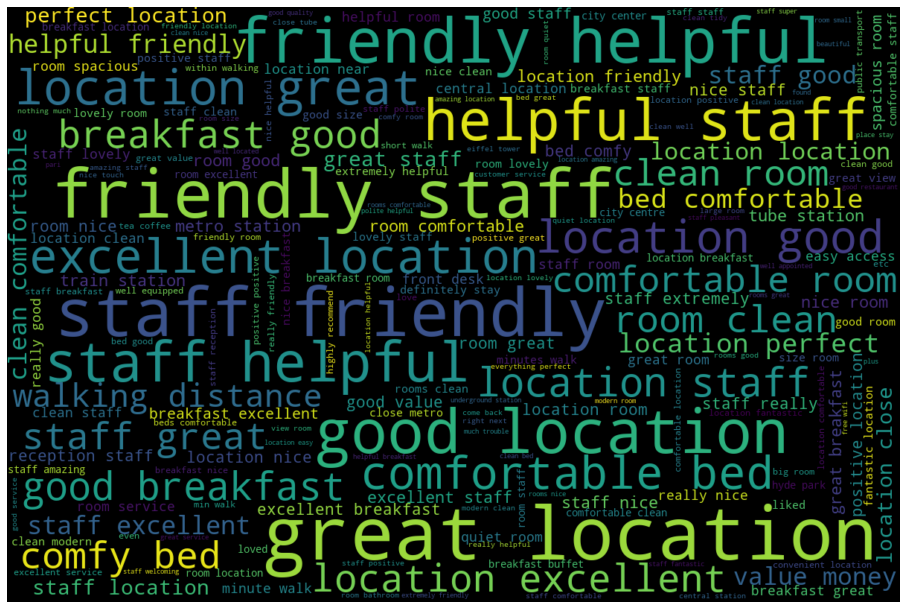

In [ ]:
pos_words=nltkzer(data, 'positive_review', stopwords)

In [ ]:
pos_wordfreq=pd.DataFrame([pos_words]).T.rename(columns={0:"Freq"})
pos_wordfreq.sort_values('Freq', ascending=False, inplace=True)
display(pos_wordfreq.head(25))

,Freq
staff,194574
location,192856
room,140746
good,112321
great,105641
friendly,85353
breakfast,84581
helpful,76183
nice,69449
clean,66929


Положительные отзывы менее разнообразны, содержат меньше деталей о пребывании в гостинице.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


definitely    5006.577
great         5159.903
recommend     5480.964
amazing       5521.792
every         5871.173
love          5975.244
friendly      6383.467
ever          6591.495
room          7273.918
per           7522.262
helpful       7720.365
hot           8170.472
help          8434.355
eat           8651.075
end           9652.291
stay         10167.703
thing        13648.766
staff        13955.532
dtype: float64

['definitely',
 'great',
 'recommend',
 'amazing',
 'every',
 'love',
 'friendly',
 'ever',
 'room',
 'per',
 'helpful',
 'hot',
 'help',
 'eat',
 'end',
 'stay',
 'thing',
 'staff']

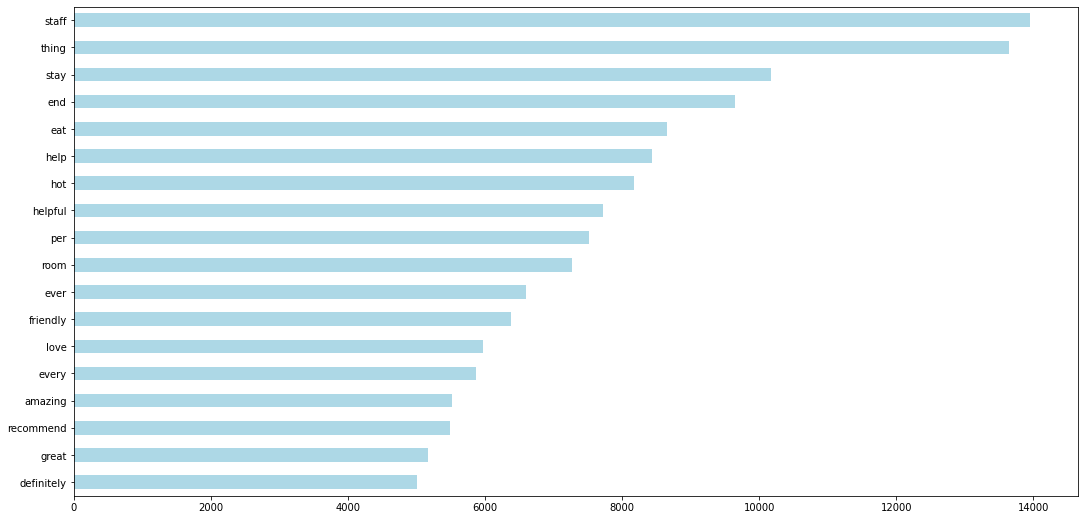

In [ ]:
top1000poswords=list(pos_wordfreq.nlargest(700, 'Freq').index)
chiboxing(bin_creator(top1000poswords, data.positive_review)[0], 5000)

pos_price           674.008
pos_light           779.659
pos_near            920.727
pos_free            939.669
pos_like           1079.328
pos_view           1340.405
pos_not            1388.369
pos_quiete         1679.342
pos_spa            1848.889
pos_questions      2257.657
pos_location       2269.850
pos_thank          2774.217
pos_want           2938.969
pos_clean          3053.333
pos_service        3768.698
pos_breakfast      4042.043
pos_advice         5442.745
pos_big room       7273.918
pos_again          7680.176
pos_hot            8417.460
pos_stay          10167.703
pos_good          10806.526
pos_very          12127.272
pos_staff         16082.563
pos_no positive   22919.076
dtype: float64

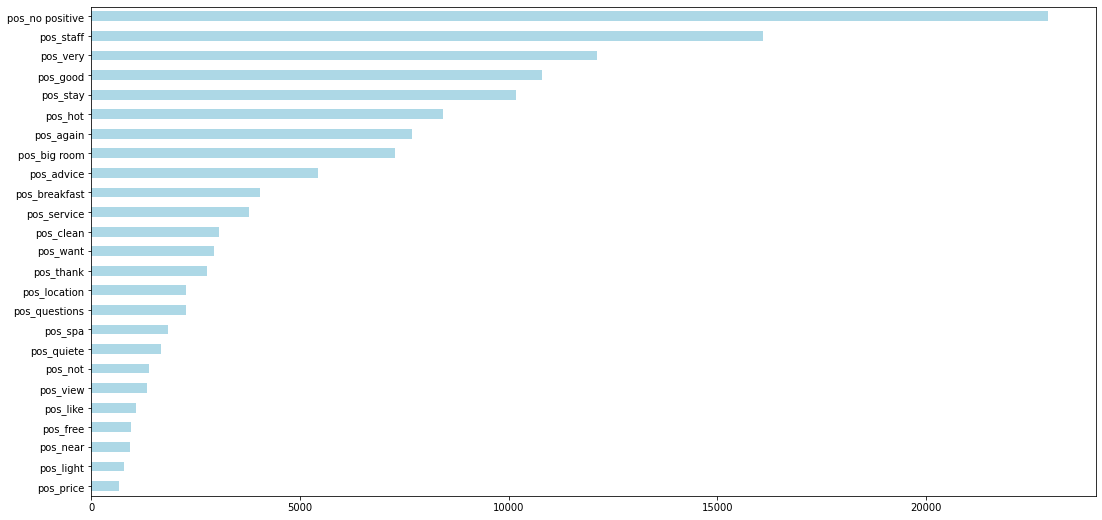

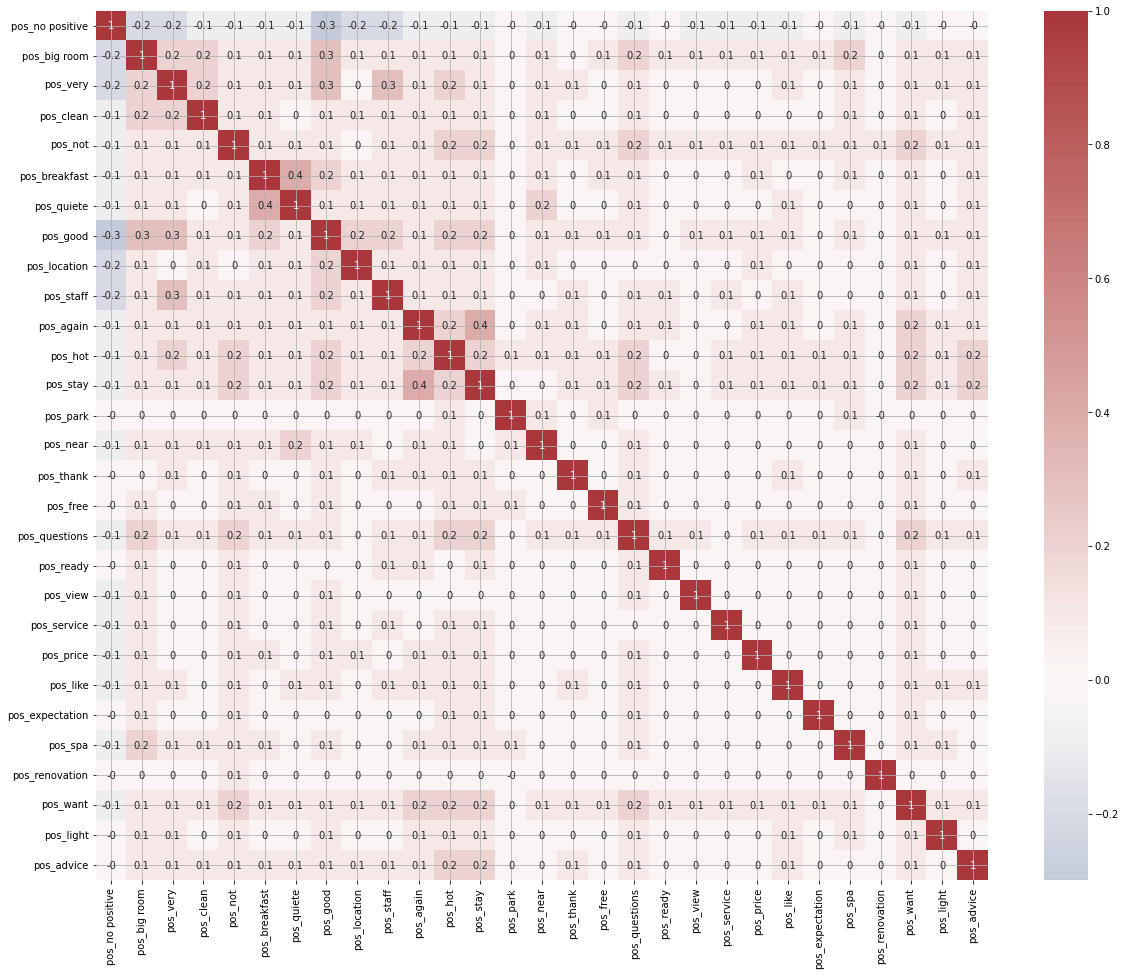

In [ ]:
data['pos_spa']=np.where(data['positive_review'].str.lower().str.contains('spa'), True, False)
data['pos_no positive']=np.where(data['positive_review'].str.lower().str.contains('no positive'), True, False)
data['pos_thank']=np.where(data['positive_review'].str.lower().str.contains('thank|grat'), True, False)
data['pos_big room']=np.where(data['positive_review'].str.contains(('big|spacious' ) and 'room'), True, False)
data['pos_very']=np.where(data['positive_review'].str.contains('very|extremly'), True, False)
data['pos_clean']=np.where(data['positive_review'].str.contains('clean'), True, False)
data['pos_breakfast']=np.where(data['positive_review'].str.contains('breakfast|tasty|delicious|restaurant'), True, False)
data['pos_not']=np.where(data['positive_review'].str.contains('not|non|no'), True, False)
data['pos_quiete']=np.where(data['positive_review'].str.contains('quiete|calm|rest'), True, False)
data['pos_good']=np.where(data['positive_review'].str
                          .contains('good|best|excellent|great|well|nice|super|cosy|comfy|vibe|relax|love|serene|comfortable|beautiful|perfect|amazing|fantastic|wonderful')
                          , True, False)
data['pos_location']=np.where(data['positive_review'].str.contains('location|place'), True, False)
data['pos_staff']=np.where(data['positive_review'].str.contains('staff|personnel|employ|welcom|help|friendly|kind|respectful'), True, False)
data['pos_again']=np.where(data['positive_review'].str.contains('again|back|return|next'), True, False)
data['pos_hot']=np.where(data['positive_review'].str.contains('hot|warm'), True, False)
data['pos_stay']=np.where(data['positive_review'].str.contains('stay'), True, False)
data['pos_park']=np.where(data['positive_review'].str.contains('park'), True, False)
data['pos_near']=np.where(data['positive_review'].str.contains('near|close'), True, False)
data['pos_questions']=np.where(data['positive_review'].str.contains('why|who|where|how|when|what'), True, False)
data['pos_ready']=np.where(data['positive_review'].str.contains('ready'), True, False)
data['pos_view']=np.where(data['positive_review'].str.contains('view'), True, False)
data['pos_service']=np.where(data['positive_review'].str.contains('service'), True, False)
data['pos_price']=np.where(data['positive_review'].str.contains('price|cost|money'), True, False)
data['pos_free']=np.where(data['positive_review'].str.contains('free'), True, False)
data['pos_like']=np.where(data['positive_review'].str.contains('like|fancy|excit|happ|please'), True, False)
data['pos_expectation']=np.where(data['positive_review'].str.contains('expect|anticipat'), True, False)
data['pos_want']=np.where(data['positive_review'].str.contains('want|do|need'), True, False)
data['pos_light']=np.where(data['positive_review'].str.contains('bright|light'), True, False)
data['pos_advice']=np.where(data['positive_review'].str.contains('advi|recomm'), True, False)
data['pos_renovation']=np.where(data['positive_review'].str.contains('renovation'), True, False)




pos_word_list=['pos_no positive', 'pos_big room',  'pos_very', 'pos_clean', 'pos_not', 'pos_breakfast', 'pos_quiete',
               'pos_good', 'pos_location', 'pos_staff', 'pos_again', 'pos_hot', 'pos_stay',
               'pos_park', 'pos_near', 'pos_thank', 'pos_free', 'pos_questions', 'pos_ready', 'pos_view',  'pos_service',
               'pos_price',  'pos_like', 'pos_expectation', 'pos_spa', 'pos_renovation', 'pos_want',
               'pos_light', 'pos_advice']


chiboxing(data[pos_word_list])

pos_words=data[pos_word_list].corr().round(1)
plt.figure(figsize=(20, 16))
sns.heatmap(pos_words,
            cmap="vlag", center=0,
            annot=True).grid(True)

Значимые корреляции между признаками отсутствуют.

Мы закончили работу с тектовыми переменными, почистив датасет мы приступаем к анализу и обработки численных переменных.

In [ ]:
data.select_dtypes(include='object').columns

Index(['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'positive_review', 'tags', 'days_since_review',
       'hotel_name_tok', 'hotel_name_words_', 'hotel_nametext_string_fdist',
       'hotel_nametext_string_lem', 'hotel_country', 'zip_code',
       'reviewers_1pct', 'country_abb', 'continent_name', 'country_abb_alpha3',
       'reviewers_UNregion', 'tags_tok', 'tags_words_',
       'tagstext_string_fdist', 'tagstext_string_lem', 'negative_review_tok',
       'negative_review_words_', 'negative_reviewtext_string_fdist',
       'negative_reviewtext_string_lem', 'positive_review_tok',
       'positive_review_words_', 'positive_reviewtext_string_fdist',
       'positive_reviewtext_string_lem'],
      dtype='object')

In [ ]:
data.drop(['hotel_name_tok', 'hotel_name_words_', 'hotel_nametext_string_fdist',
       'hotel_nametext_string_lem'], axis=1, inplace=True)

In [ ]:
data.columns.to_list()

['hotel_address',
 'additional_number_of_scoring',
 'review_date',
 'average_score',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'positive_review',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'tags',
 'days_since_review',
 'lat',
 'lng',
 'sample',
 'reviewer_score',
 'best_western',
 'holiday inn',
 'kensington',
 'park',
 'paddington',
 'Grand Royale London Hyde Park',
 'The Cumberland A Guoman Hotel',
 'BEST WESTERN Maitrise Hotel Maida Vale',
 'Holiday Inn London Kensington',
 'NH Carlton Amsterdam',
 'Shaftesbury Premier London Paddington',
 'Park Lane Mews Hotel',
 'Hyatt Regency Paris Etoile',
 'Gainsborough Hotel',
 'Henry VIII',
 'Hilton London Metropole',
 'Bloomsbury Palace Hotel',
 'Commodore Hotel',
 'Hotel Cavendish',
 'Intercontinental London The O2',
 'rev_top_100_hotels_list',
 'av_top_100_hotels_list',
 'est_consensus',
 'hotel_country',
 'zip_c

In [ ]:
data.drop([
#  'hotel_name_tok',
#  'hotel_name_words_',
#  'hotel_nametext_string_fdist',
#  'hotel_nametext_string_lem',
 'rev_top_100_hotels_list',
 'country_abb',
 'continent_name',
 'country_abb_alpha3',
 'reviewers_UNregion',
 'tags_tok',
 'tags_words_',
 'tagstext_string_fdist',
 'tagstext_string_lem',
 'negative_review_tok',
 'negative_review_words_',
 'negative_reviewtext_string_fdist',
 'negative_reviewtext_string_lem',
 'positive_review_tok',
 'positive_review_words_',
 'positive_reviewtext_string_fdist',
 'positive_reviewtext_string_lem'], axis=1, inplace=True)

In [ ]:
data.info(False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Columns: 128 entries, hotel_address to pos_renovation
dtypes: bool(103), float64(5), int64(9), object(11)
memory usage: 149.0+ MB


#### **ПРИЗНАКИ В ЧИСЛОВОМ ФОРМАТЕ**

Разобравшись с текстовыми переменными, переходим к числовым переменным

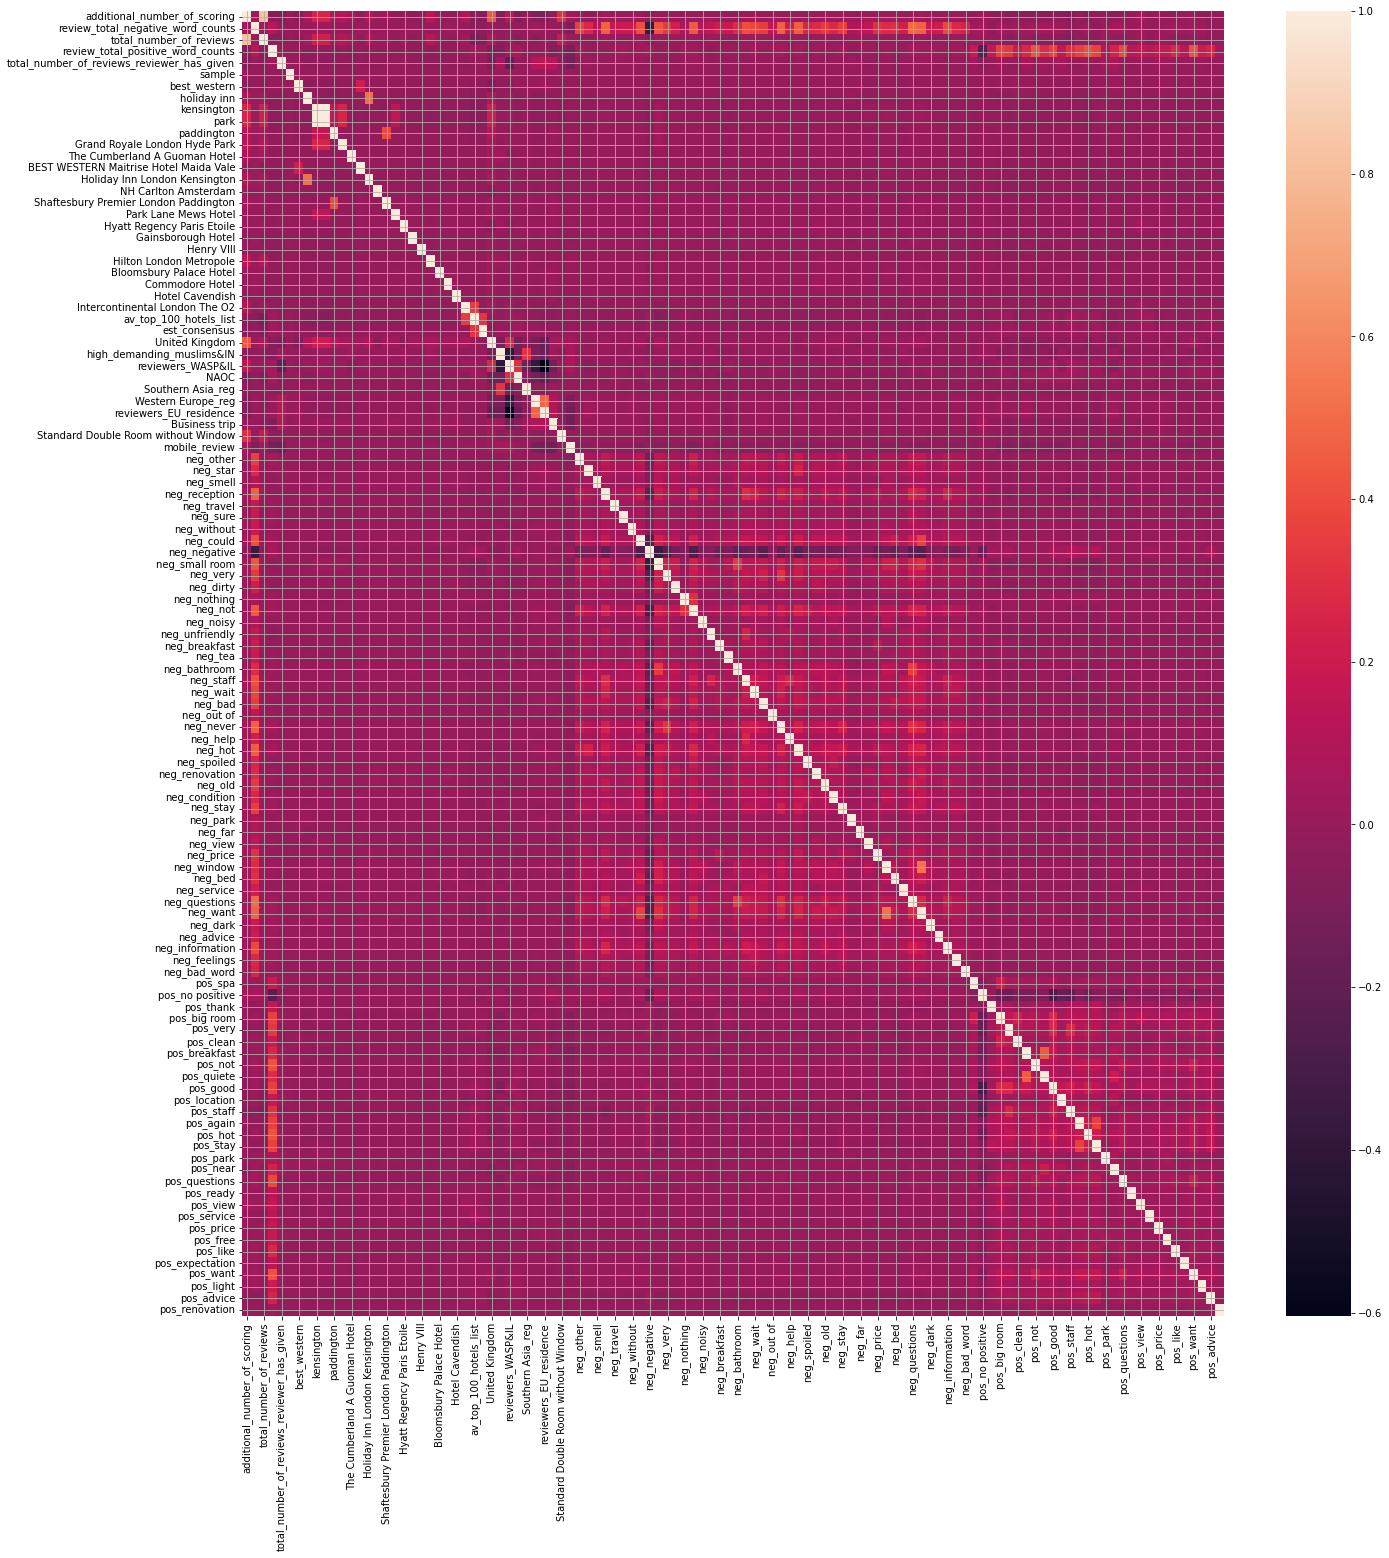

In [ ]:
plt.figure(figsize=[22, 24])
sns.heatmap(data.select_dtypes(exclude=['object','float']).corr()).grid(True)

Рассмотрим исходные числовые признаки (держа в памяти признаки даты размещения рецензии и дней с момента отзыва, их мы добавим позже)

In [ ]:
data.iloc[:,:16].select_dtypes(exclude='object')

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng
0,904,8.100,52,16670,62,1,45.533,9.171
1,612,8.600,10,5018,0,7,52.386,4.834
2,46,8.300,3,351,5,15,41.393,2.162
3,241,9.100,0,1543,27,9,45.480,9.196
4,834,9.100,0,4687,7,2,52.371,4.889
...,...,...,...,...,...,...,...,...
515733,107,9.000,0,617,10,10,51.494,-0.191
515734,272,8.400,0,3224,93,1,48.192,16.399
515735,457,6.800,12,2751,9,21,51.521,-0.131
515736,365,8.100,0,1567,6,28,51.515,-0.160


Оценимм значимость признаков прогнав их через chiboxing

In [ ]:
# anovaboxing(data.iloc[:,:14].drop('reviewer_score', axis=1).select_dtypes(exclude='object'))

Попробуем пролагорифмировать переменные, в ноубуке укажем только те результаты которые являются улучшениями в сравнение с исходными.

total_number_of_reviews                        77.774
total_number_of_reviews_reviewer_has_given     95.707
review_total_positive_word_counts            1531.579
review_total_negative_word_counts            3197.087
dtype: float64

['total_number_of_reviews',
 'total_number_of_reviews_reviewer_has_given',
 'review_total_positive_word_counts',
 'review_total_negative_word_counts']

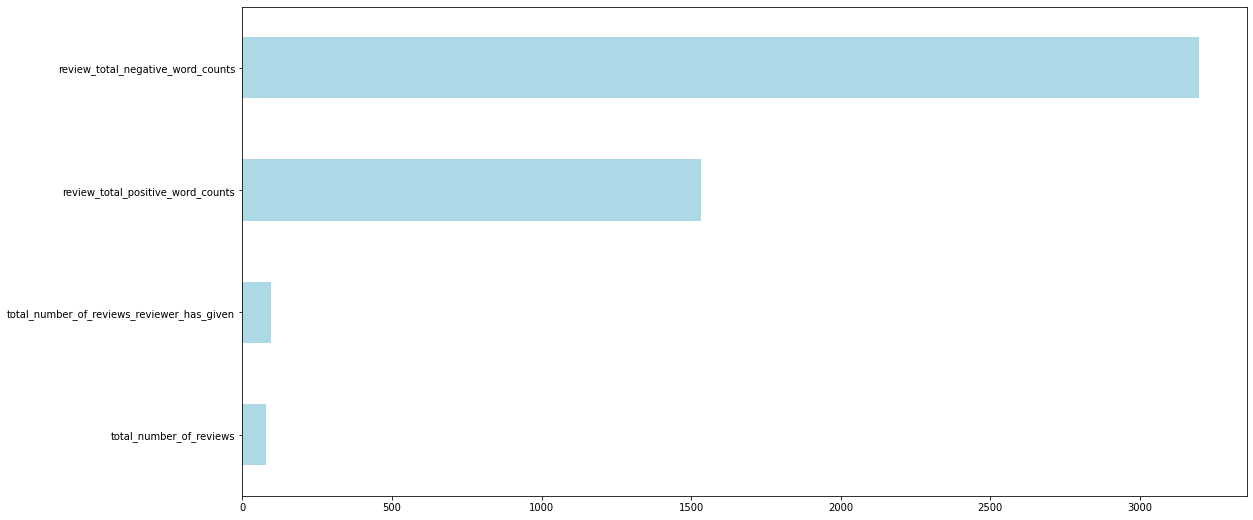

In [ ]:
anovaboxing(data[['review_total_negative_word_counts', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
                  'total_number_of_reviews']].transform(lambda x
                                                        : np.log10(x+1)))

У нас резко выросла значимость признаков (в 2 раза для review_total_negative_word_counts и почти в 3 раза для review_total_positive_word_counts)! Заменим значения логорифмами.

In [ ]:
data['log_review_total_negative_word_counts']=data['review_total_negative_word_counts'].transform(lambda x: np.log10(x+1))
data['log_review_total_positive_word_counts']=data['review_total_positive_word_counts'].transform(lambda x: np.log10(x+1))
data['log_tot_num_of_reviews_by_reviewer']=data['total_number_of_reviews_reviewer_has_given'].transform(lambda x: np.log10(x+1))
data['log_total_number_of_reviews']=data['total_number_of_reviews'].transform(lambda x: np.log10(x+1))
data.drop(['review_total_negative_word_counts', 'review_total_positive_word_counts',
           'total_number_of_reviews_reviewer_has_given',  'total_number_of_reviews'], axis=1, inplace=True)

Вернёмся к признакам получаемым из текстовых переменных

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


dayofyear   12.460
month       12.742
week        12.837
quarter     14.631
dtype: float64

['dayofyear', 'month', 'week', 'quarter']

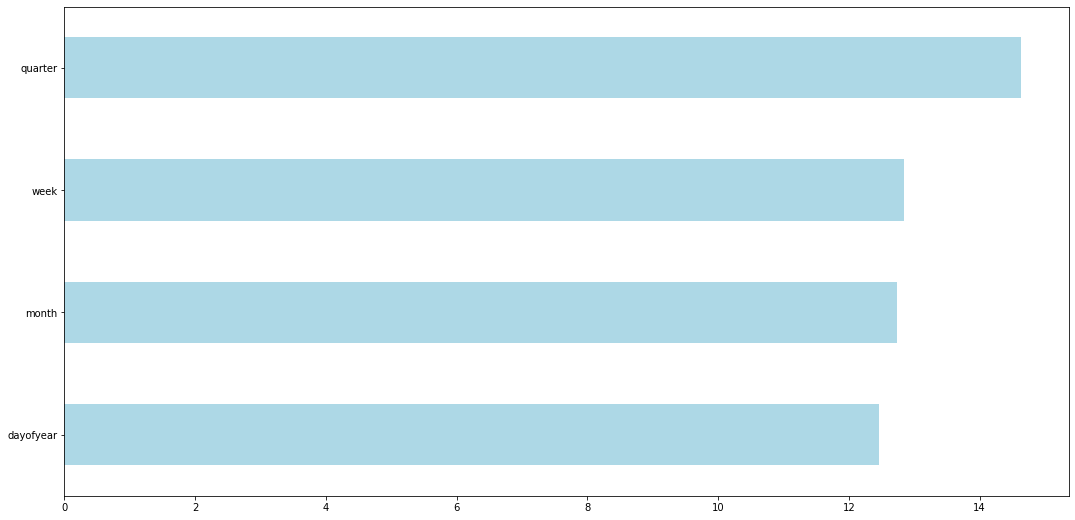

In [ ]:
datetiming_list=['year', 'quarter', 'month', 'week', 'day', 'dayofweek', 'dayofyear', 'weekday',
                 'is_month_start']
datetiming=pd.to_datetime(data['review_date'])
a=[getattr(datetiming.dt, i) for i in datetiming_list]
anovaboxing(pd.DataFrame(a, index=datetiming_list).T, 10)

Все полученные из даты временные признаки не дотягивают до установленного нами порога отсечения значимости, и мы не будем их добавлять в модель.

#### **'lat' & 'Lng'**

Проанализируем данные по координатам отелей.

У нас имеются пропуски в данных по координатам некоторых отелей. Заменяем отсутствующие данные на модальные географические координаты отелей,
относящихся к тому же почтовому подразделению.

Далее мы определим расстояние от отеля до географического центра города в котором он расположен.

In [ ]:
# Заменяем отсутствующие данные по географическим координатам на модальные данные
# почтового подразделения

abscent_gps=data[data.lat.isna()].zip_code
abscent_gps=abscent_gps.to_list()
zip_median_substitutor_lat=data[data.
                                zip_code.
                                isin(abscent_gps)].groupby('zip_code')['lat'].agg(pd.Series.mode).T.to_dict()
zip_median_substitutor_lng=data[data.zip_code.isin(abscent_gps)].groupby('zip_code')['lng'].agg(pd.Series.mode).T.to_dict()

data.loc[data.lat.isna(),
         'lat']=data.loc[data.lat.isna(),
                         'zip_code'].map(zip_median_substitutor_lat)

data.loc[data.lng.isna(),
         'lng']=data.loc[data.lng.isna(),
                         'zip_code'].map(zip_median_substitutor_lng)


In [ ]:
centers = pd.DataFrame(
    data = [
        ['United Kingdom', 'London', 51.5085300, -0.1257400],
        ['France', 'Paris', 48.8534100, 2.3488000],
        ['Spain', 'Barcelona', 41.3887900, 2.1589900],
        ['Italy', 'Milan', 45.4642700, 9.1895100],
        ['Austria', 'Vienna', 48.2084900, 16.3720800],
        ['Netherlands', 'Amsterdam', 52.3740300, 4.8896900],
    ],
    columns= ['country', 'city', 'center_lat', 'center_lng']
).set_index('country')

In [ ]:
def dist_to_center(country, lng, lat):
    """Вычисление дистанции до центра города по координатам."""
    center_lat = centers['center_lat'][country]
    center_lng = centers['center_lng'][country]

    return geopy.distance.geodesic([center_lng, center_lat], [lng, lat]).km


In [ ]:
hotels_coord=data[['hotel_name', 'hotel_country', 'lng', 'lat']].drop_duplicates()
hotels_coord['distance']=hotels_coord.apply(lambda x: dist_to_center(x.hotel_country, x.lng, x.lat), axis=1)

In [ ]:
data = data.merge(hotels_coord[['hotel_name', 'distance']],
                  how='left', on='hotel_name', sort=False)

Ввёдём дополнительный признак - десятичный логарифм расстояния до центраи оценим наши признаки

logDdist   103.686
dtype: float64

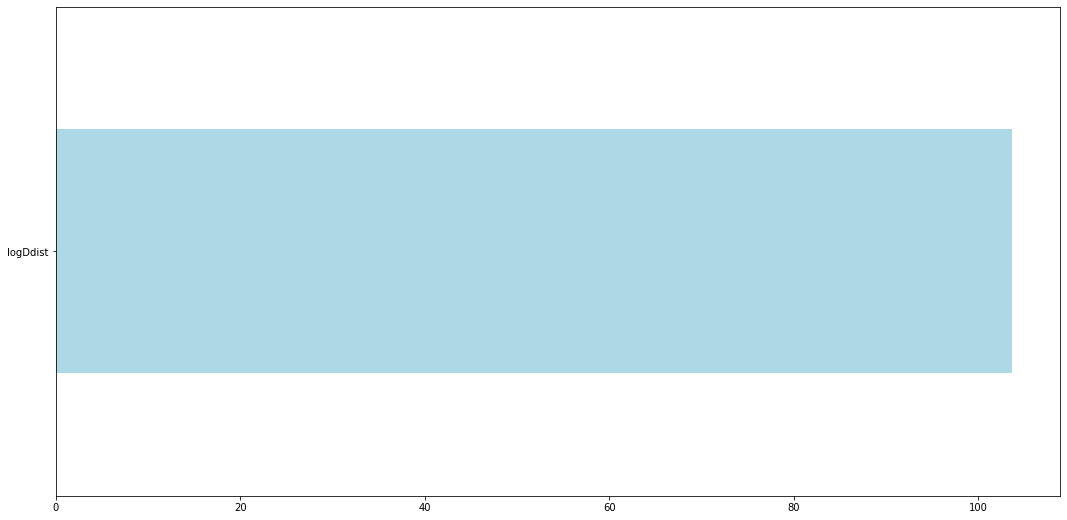

In [ ]:
data['logDdist']=np.log10(data['distance'])
gps_dist=anovaboxing(data['logDdist'])
data.drop('distance', axis=1, inplace=True)

In [ ]:
data.drop(['lat', 'lng'], axis=1, inplace=True)

Признаки времени показали очень низкий уровень влияния на целевую переменную и мы не будем включать их в модель.

In [ ]:
# data.days_since_review
# datetiming=pd.to_datetime(data['review_date'])
# rev_period=datetiming.agg(['min', 'max']).diff()[1].days
# datetiming.agg(['min', 'max'])

# # Name: review_date, dtype: datetime64[ns]

# datetiming_list=['year', 'quarter', 'month', 'week', 'weekofyear', 'day', 'dayofweek', 'dayofyear', 'is_month_start']

# for i in datetiming_list:
#     data[i] = getattr(datetiming.dt, i)
# #     corrcoeff=stats.spearmanr(data[i], data.reviewer_score)
# #     print('Коэффициент корреляции Спирмена для признака {} = {} с уровнем значимости {}'.format(i, corrcoeff[0].round(3), corrcoeff[1]))


# # В ручную настраиваем диапазон медианно более высоких оценок. Он захватывает период от католического рождества

# X_mas_range_1516=pd.date_range(start='12/18/2015', end='01/02/2016').strftime("%Y-%m-%d").tolist()
# X_mas_range_1617=pd.date_range(start='12/18/2016', end='01/02/2017').strftime("%Y-%m-%d").tolist()
# X_mas_range=X_mas_range_1516+X_mas_range_1617
# data['X-mas_time']=np.where(datetiming.isin(X_mas_range), True, False)
# stats.spearmanr(data['X-mas_time'], data.reviewer_score)

# # data[['year', 'quarter', 'day', 'dayofweek', ]].corr().round(2)

# # Самый высокий коэффициент корреляции наблюдается для признака 'quarter'. Он линенйно независим от параметров year, quarter, day, dayofweek и сильно опережает их по значимости. Поэтому из данного списка аттрибутов мы в качестве признака выбираем параметр quarter.

# # Также вводим признак сезонности(больше положительных отзывов в декабре-апреле и в августе(месяц отпусков).

# # dates_pivot_table=data.pivot_table(index='month', columns='day', values='average_score', aggfunc='median')

# sns.heatmap(dates_pivot_table)

# <AxesSubplot:xlabel='day', ylabel='month'>



# # data['seasons']=np.where(data.month.isin([1, 2, 3, 4, 5, 8, 12]), True, False)
# # stats.spearmanr(data['seasons'], data.average_score)


# # SpearmanrResult(correlation=0.0077088726033553165, pvalue=3.091256472762422e-08)

### **ДООЧИСТКА ДАННЫX**

Почистим данные от дублирующихся или коррелированных признаков


In [ ]:
# data.drop(['rev_top_100_hotels_list', 'Western Europe_reg', 'Northern Europe_reg',
#            'Western Asia_reg', 'Northern America_reg','nights',
#             'distance_x', 'distance_y', 'days_cat'
# #             # 'window', 'without',
#            ], axis=1, inplace=True)

Для уменьшения размера файла, заменим форматы на их более экономные аналоги

Удаляем ставшие тепепь нам ненужными признаки в текстовом формате

In [ ]:
data=data.select_dtypes(exclude='object')
data.info(False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Columns: 116 entries, additional_number_of_scoring to logDdist
dtypes: bool(103), float64(8), int64(5)
memory usage: 105.7 MB


In [ ]:
data.select_dtypes('int').agg(['min', 'max']).T

,min,max
additional_number_of_scoring,1,2682
sample,0,1
av_top_100_hotels_list,0,1
est_consensus,0,1
reviewers_EU_residence,0,1


In [ ]:
data[data.select_dtypes('int').columns]=data.select_dtypes('int').astype('uint16')

In [ ]:
data.dtypes.value_counts()

bool       103
float64      8
uint16       5
dtype: int64

In [ ]:
data.info(False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Columns: 116 entries, additional_number_of_scoring to logDdist
dtypes: bool(103), float64(8), uint16(5)
memory usage: 91.0 MB


In [ ]:
data.select_dtypes('float')

,average_score,reviewer_score,nights,log_review_total_negative_word_counts,log_review_total_positive_word_counts,log_tot_num_of_reviews_by_reviewer,log_total_number_of_reviews,logDdist
0,8.100,0.000,2.000,1.724,1.799,0.301,4.222,0.894
1,8.600,0.000,1.000,1.041,0.000,0.903,3.701,0.795
2,8.300,0.000,1.000,0.602,0.778,1.204,2.547,-0.249
3,9.100,0.000,1.000,0.000,1.447,1.000,3.189,0.273
4,9.100,0.000,2.000,0.000,0.903,0.477,3.671,-0.394
...,...,...,...,...,...,...,...,...
515733,9.000,8.800,2.000,0.000,1.041,1.041,2.791,0.869
515734,8.400,9.200,4.000,0.000,1.973,0.301,3.509,0.542
515735,6.800,8.300,1.000,1.114,1.000,1.342,3.440,0.173
515736,8.100,9.200,2.000,0.000,0.845,1.462,3.195,0.587


neg_bad_word              3031.788
neg_without               3037.456
pos_clean                 3053.333
neg_noisy                 3742.503
pos_service               3768.698
pos_breakfast             4042.043
neg_breakfast             4042.392
Business trip             4207.179
neg_advice                4326.998
neg_feelings              4445.993
neg_other                 5328.127
neg_help                  5385.906
pos_advice                5442.745
neg_smell                 5601.970
neg_wait                  7133.717
neg_service               7180.943
pos_big room              7273.918
neg_window                7283.480
neg_stay                  7392.124
pos_again                 7680.176
av_top_100_hotels_list    8166.284
pos_hot                   8417.460
neg_information           8884.986
neg_condition             8887.117
pos_stay                 10167.703
neg_unfriendly           10538.954
neg_spoiled              10676.456
pos_good                 10806.526
neg_renovation      

['neg_bad_word',
 'neg_without',
 'pos_clean',
 'neg_noisy',
 'pos_service',
 'pos_breakfast',
 'neg_breakfast',
 'Business trip',
 'neg_advice',
 'neg_feelings',
 'neg_other',
 'neg_help',
 'pos_advice',
 'neg_smell',
 'neg_wait',
 'neg_service',
 'pos_big room',
 'neg_window',
 'neg_stay',
 'pos_again',
 'av_top_100_hotels_list',
 'pos_hot',
 'neg_information',
 'neg_condition',
 'pos_stay',
 'neg_unfriendly',
 'neg_spoiled',
 'pos_good',
 'neg_renovation',
 'neg_price',
 'neg_star',
 'pos_very',
 'neg_could',
 'neg_never',
 'neg_bathroom',
 'neg_bed',
 'neg_old',
 'pos_staff',
 'neg_very',
 'neg_questions',
 'neg_dirty',
 'neg_bad',
 'neg_hot',
 'neg_want',
 'neg_not',
 'neg_staff',
 'neg_reception',
 'pos_no positive',
 'neg_small room',
 'neg_negative']

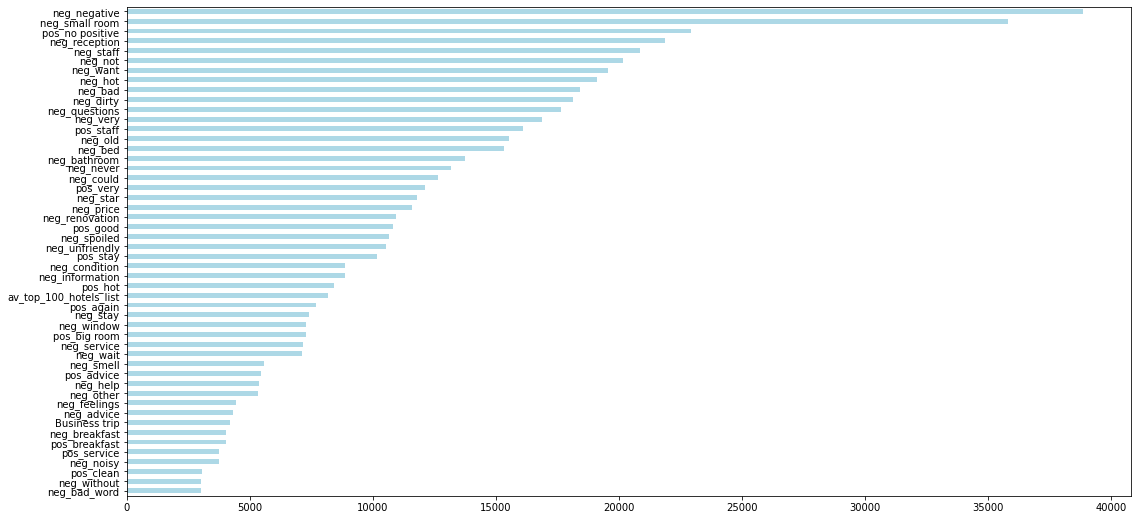

In [ ]:
dins=data[data.columns[data.nunique()==2]]
chiboxing(dins, 3000)

Проверим на значимость всех отобранных нами параметров

log_total_number_of_reviews               77.774
log_tot_num_of_reviews_by_reviewer        95.707
logDdist                                 103.686
log_review_total_positive_word_counts   1531.579
average_score                           1731.272
log_review_total_negative_word_counts   3197.087
dtype: float64

['log_total_number_of_reviews',
 'log_tot_num_of_reviews_by_reviewer',
 'logDdist',
 'log_review_total_positive_word_counts',
 'average_score',
 'log_review_total_negative_word_counts']

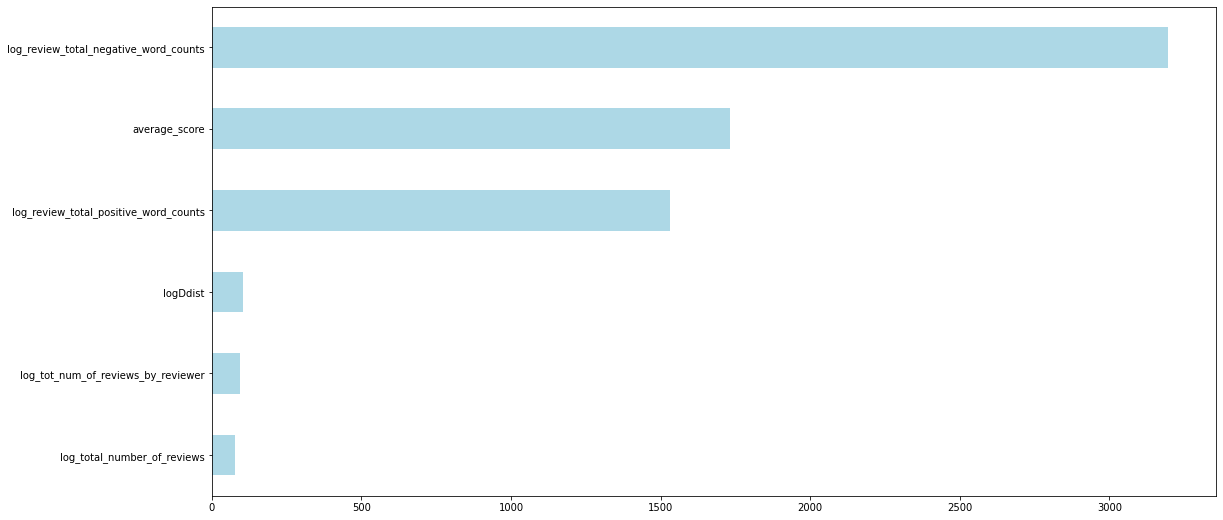

In [ ]:
anovaboxing(data[data.columns[data.nunique()>2]].drop('reviewer_score', axis=1), 50)


In [ ]:
data=data.select_dtypes(exclude='O')

# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape


((128935, 115), (386803, 115), (386803, 114), (309442, 114), (77361, 114))

In [ ]:

from sklearn.feature_selection import f_classif, mutual_info_classif


X = data.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# # визуализируем результат анализа значимости:
# imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
# imp_num.sort_values(inplace = True)

# fig5, ax5 = plt.subplots(figsize=(15, 20))
# imp_num.plot(kind = 'barh', color='green');



In [ ]:
# X = data.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)
# y_train1=y_train.astype(int)
# mutual_info = mutual_info_classif(X_train.values, y_train1)

In [ ]:
# mutual_info

In [ ]:
# a=list(mutual_info)

# mutuals=pd.Series(dict(zip(X.columns, a)))
# mutuals.sort_values(inplace=True, ascending=False)


# # mutsel=mutuals[mutuals>=0.005].index
# mutsel=mutuals.nlargest(40).index

In [ ]:
# mutsel

In [ ]:
# datasel[['sample', 'reviewer_score']]

In [ ]:
# datasel=pd.concat([data[['sample', 'reviewer_score']], data[mutsel]], axis=1).copy()

In [ ]:
# X = datasel.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)
# y = datasel.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
# test_data = datasel.query('sample == 0').drop(['sample'], axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.9s finished


MAPE: 0.8823167065795218


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    4.8s finished


['reviewer_score', 'id']

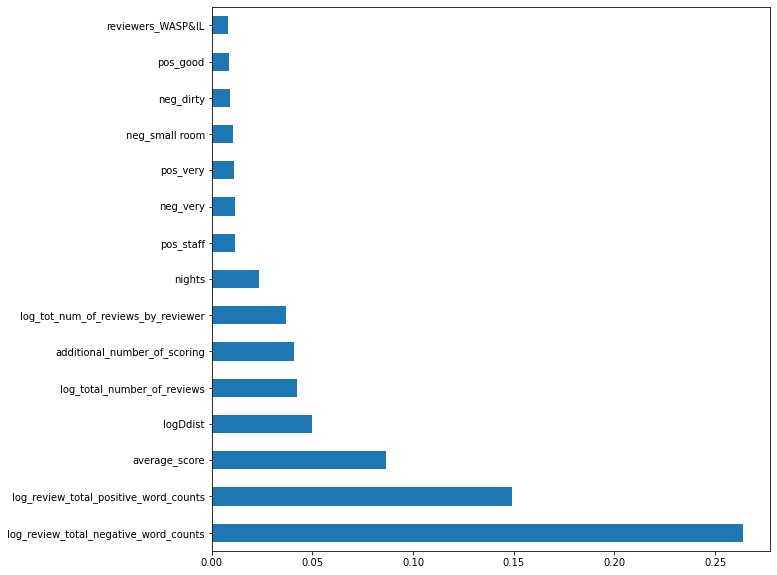

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)


# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))


# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

test_data.sample(10)

test_data = test_data.drop(['reviewer_score'], axis=1)


predict_submission = model.predict(test_data)

list(sample_submission)

# sample_submission['reviewer_score'] = predict_submission
# sample_submission.to_csv('submission.csv', index=False)
# sample_submission.head(10)

# sample_submission1['reviewer_score']= predict_submission.round(2)
# sample_submission1.to_csv('submission.csv', index=False)




In [ ]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.head(10)
sample_submission.to_csv('/content/drive/MyDrive/BOOKING/submission.csv', index=False)

In [ ]:
data.days_since_review=data.days_since_review.str.split(pat=('day' or 'days'),
                                                        expand=True)[0].astype(int)

### **ЗАКЛЮЧЕНИЕ**

In [ ]:
Построена модель с ошибкой равной 12.77323 (https://www.kaggle.com/submissions/28135972/28135972.raw).
Я решил не использовать продвинутые методы анализа тональности пока в них не разберусь.